
# Accelerating Monte Carlo

Here we summarize the most relevant results achieved during the project. We provide a brief description of the theoretical framework, the code and the plots in order to be as clear as possible.


## Theory

-----



### Model



$$
H(\mathbf{\sigma}) = \sum_{i=1}^{N} J_{ij}\sigma_i\sigma_j
$$
with the coupling strength between spin $i$ and $j$ $J_{ij}\in[-1,1]$ uniformly distributed and $\sigma_i \in \{\pm1\}$. $\mathbf{\sigma} = (\sigma_1, \dots, \sigma_N)$ indicates the spin configuration.
We are interested in the thermodynamic properties such as the average energy $E=\langle H(\mathbf{\sigma})\rangle$ or the magnetization $m=\langle \sum_{i=1}^N{\sigma_i} \rangle$, where the brackets indicate the expectation value over the Boltzmann distribution
$$
P(\mathbf{\sigma}) = \exp{[-\beta H(\mathbf{\sigma})]} / Z, 
$$ 
where $\beta=1/k_BT$ is the inverse temperature, $k_B=1$ the Boltzmann constant, T the temperature and $Z=\sum_{\mathbf{\sigma}}{\exp{[-\beta H(\mathbf{\sigma})]}}$ is the partition function.


### Method



The properties defined above can be computed with a stochastic Markov Chain in the configuration space, driven by by a suitable transition matrix. Each entry of the matrix $T_{\mathbf{\sigma'}\mathbf{\sigma}}$ represent the probability to move from the configuration $\mathbf{\sigma'}$ to $\mathbf{\sigma}$, thus must apply the *datailed balance condition* $T_{\mathbf{\sigma'}\mathbf{\sigma}} \geq 0$ and $\sum_{\mathbf{\sigma'}}{T_{\mathbf{\sigma'}\mathbf{\sigma}}} = 1$ for any $\mathbf{\sigma}$. A common procedure is to decompose $T_{\mathbf{\sigma'}\mathbf{\sigma}} = \omega_{\mathbf{\sigma'}\mathbf{\sigma}}A_{\mathbf{\sigma'}\mathbf{\sigma}}$ for $\mathbf{\sigma'} \neq \mathbf{\sigma}$, where $\omega_{\mathbf{\sigma'}\mathbf{\sigma}}$ is the probability to propose moving from $\mathbf{\sigma}$ to $\mathbf{\sigma'}$ and $A_{\mathbf{\sigma'}\mathbf{\sigma}}$ is the probability to accept the proposed update.

The Metropolis-Hastings algorithm is a way to satisfy the detailed balance condition, where they defined the acceptance probability as 
$$
A_{\mathbf{\sigma}'\mathbf{\sigma}} = \min\left(1, \frac{p(\mathbf{\sigma}')\omega_{\mathbf{\sigma}\mathbf{\sigma}'}}{p(\mathbf{\sigma})\omega_{\mathbf{\sigma}'\mathbf{\sigma}}}\right).
$$
One can consider a symmertic proposal distribution, as in the single spin-flip algorithm where we chose uniformly a spin $i$ and propose to flip it. In that case the acceptance probability involves only the Boltzmann probability $P(\mathbf{\sigma})$, i.e., $A_{\mathbf{\sigma}'\mathbf{\sigma}} = \min\left(1, \frac{P(\mathbf{\sigma}')}{P(\mathbf{\sigma})}\right)$.


#### Autoregressive Neural Network 



As explained in the paragraph above, we can change the proposal distribution, keeping in mind the detailed balance condition. *Machine Learning* (ML) gives us a possible alternative method. in particular a subclass of Neural Networks (NN), the Autoregressive Neural Networks (ANN) that aim to solve the general problem of the *distribution estimation*. The distribution estimation is the task of estimating a joint distribution $p(\mathbf{x})$ from a set of examples $\{\mathbf{x}^{(t)}\}^T_{t=1}$.
The data generation usually is made sampling a latent state $\mathbf{h}$ from some prior $p(\mathbf{h})$, then sampling the observed data $\bf{x}$ from some conditional $p(\mathbf{x} \mid \mathbf{h})$.

So we introduce a particular ANN, called **M**asked **A**utoregressive **D**ensity **E**stimator (**MADE**), that we will use as a proposal generator for the Markov Chain Monte Carlo (MCMC).

Here and in the following, we consider a training set of examples $\left\{\mathbf{x}^{(t)}\right\}_{t=1}^T$ where each input is a $D$-dimensional array $\mathbf{x} = (x_1, \dots, x_D)$ with $x_d \in \{0,1\}$.
The aim of an autoencoder is to obtain an hidden representation $\bf{h(x)}$ of the input $\bf{x}$, and then obtain a reconstruction $\hat{\mathbf{x}}$ as close as possible to $\mathbf{x}$. Thus we have
$$
\mathbf{h}(\mathbf{x}) = \mathbf{g}\left(\mathbf{b} + \mathbf{W}\mathbf{x}\right), \\
\hat{\mathbf{x}} = \sigma\left(\mathbf{c} + \mathbf{V}\mathbf{h}(\mathbf{x})\right),
$$
where $\mathbf{W}$ and $\mathbf{V}$ are matrices, $\mathbf{b}$ and $\mathbf{c}$ are vectors, $g=\text{ReLU}(x)$ and $\sigma(x)=1 / (1 + \exp(-a))$. 
The neural network is trained by minimizing the binary cross-entropy loss function
$$
\ell(\mathbf{x})= \sum_{d=1}^D -x_d\log(\hat{x}_d) -(1-x_d)\log(1-\hat{x}_d).
$$
Treating $\hat{x}_d$ as the probability that $x_d$ is 1, i.e., $p(x_d=1)$, the cross-entropy is nothing more than the negative log-likelihood function. The neural network is then trained optimizing the parameters $\left \{\mathbf{W}, \mathbf{V}, \mathbf{b}, \mathbf{c} \right\}$.

We impose then that the output of the NN can be used as a probability. We exploit the so called *autoregressive property*, where each dimension of input $\mathbf{x}$ is predicted sequentially. More precisely, we can decompose the probability into the product 
$$
p(\mathbf{x}) = \prod_{d=1}^{D} p(x_d \mid \mathbf{x}_{<d}),
$$
where $\mathbf{x}_{<d} = \left( x_1, x_2, \dots, x_{d-1} \right)$ is a vector with the first $d$ elements of the input. So, assuming $p(x_d = 1 \mid \mathbf{x}_{<d}) = \hat{x}_d$ and thus $p(x_d = 0 \mid \mathbf{x}_{<d}) = 1 - \hat{x}_d$, the cross-entropy loss function becomes a proper negative log-likelihood
$$
-\log p(\mathbf{x}) = \sum_{d=1}^D -\log p(x_d \mid \mathbf{x}_{<d})= \sum_{d=1}^D -x_d\log p(x_d \mid \mathbf{x}_{<d}) - (1-x_d)\log p(x_d \mid \mathbf{x}_{<d}) = \ell(\mathbf{x}).
$$

In order for the NN to satisfy the autoregressive property, one has to *mask* some connections. In fact, to decompose the probability into a product, the output $\hat{x}_d$  has to be independent from the subsequent inputs $\mathbf{x}_{>d} = \left( x_d, \dots, x_D \right)$, thus the weight matrices ($\mathbf{W}$ and $\mathbf{V}$) must have zeros on the connections that we need to remove. Therefore, we define two masks $\mathbf{M^W}$ and $\mathbf{M^V}$ for $\mathbf{W}$ and $\mathbf{V}$ such that
$$
\mathbf{h}(\mathbf{x}) = \mathbf{g}\left(\mathbf{b} + \left( \mathbf{W} \cdot \mathbf{M^W}\right) \mathbf{x}\right), \\
\hat{\mathbf{x}} = \sigma\left(\mathbf{c} + \left(\mathbf{V} \cdot \mathbf{M^V}\right) \mathbf{h}(\mathbf{x})\right),
$$
where $\cdot$ indicates the element-wise product.


#### Monte Carlo Algorithms



##### Neural Markov Chain Monte Carlo (N-MCMC) 



We describe here how to use the neural network inside the Monte Carlo algorithm as a smart proposal. We called this procedure *Neural Markov Chain Monte Carlo* (N-MCMC). When using the ANN as a configuration proposal, the Metropolis-Hastings acceptance probability becomes
$$
A_{\mathbf{\sigma}'\mathbf{\sigma}} = \min\left(1, \frac{p(\mathbf{\sigma}')q(\mathbf{\sigma})}{p(\mathbf{\sigma})q(\mathbf{\sigma}')}\right),
$$
where $p$ is the Boltzmann probability without the normalization term $Z$ and $q$ is the probability of the sample computed by the ANN.

The dataset needed to train the **MADE** is generated using the [D-Wave](https://www.dwavesys.com/) quantum system. The D-Wave system is a quantum annealer with up to 5000 qubits. An Ising model can be easily mapped into this kind of annealer to perform adiabatic quantum computation to obtain the ground state of $H$. Since we are in NISQ regime, we cannot expect the D-Wave annealer to *always* sample the ground state, but it provides low-energy configuration, which can be useful to simulate the low-temperature dynamics.

The algorithm runs as follows:

- Generate the dataset with the quantum annealer;
- Train an ANN; 
- Generate new sample using the trained ANN;
- Perform a Monte Carlo using the ANN as a smart proposal.


##### Hybrid Markov Chain Monte Carlo (N-MCMC)


The *pure* neural MCMC can lead some bias in the estimation of the thermodynamics properties, mostly because the dataset itself has a bias to the low-energy regime. Thus, for instance, the error in energy estimation is greater the higher the temperature. This issue can be easily solved, since at high temperature regime the classic algorithms such as the single spin-flip Monte Carlo perform quite well. 

So we exploit both the algorithms, neural and single spin flip, to achieve good performance in every regime. We called this procedure *Hybrid Markov Chain Monte Carlo* (H-MCMC) and it runs as follow:

- Generate the dataset with the quantum annealer;
- Train an ANN; 
- Generate new sample using the trained ANN;
- Perform a Monte Carlo:
     - Neural step using the ANN proposal;
     - Classic single spin step.

In our simulation a single spin-flip step is a sweep, i.e., a flip attempt for every spin in the configuration.
The acceptance rate is slightly different, in particular, it depends on the type of the next step in the simulation: when the next step is a single spin flip we have
$$
A_{\mathbf{\sigma}'\mathbf{\sigma}} = \min\left(1, \frac{p(\mathbf{\sigma}')}{p(\mathbf{\sigma})}\right),
$$
though if the next step is a neural one we have
$$
A_{\mathbf{\sigma}'\mathbf{\sigma}} = \min\left(1, \frac{p(\mathbf{\sigma}')q(\mathbf{\sigma})}{p(\mathbf{\sigma})q(\mathbf{\sigma}')}\right),
$$ 
where $p$ is the Boltzmann probability without the normalization term $Z$ and $q$ is the probability of the sample computed by the ANN.


## Results

-----


In [1]:
# imports
import json
import os

import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf

from src.utils.montecarlo import single_spin_flip, neural_mcmc
from src.utils.plt_utils import (
    get_errorbar,
    plot_hist,
    plt_acf,
    plt_betas_ar,
    plt_eng_chains,
    plt_eng_step,
)
from src.utils.utils import block_single_std, block_std, get_energy

plt.style.use('./images/paper.mplstyle')


### Ising model 100 spins and 1NN couplings

Here and in the following we focus on a fixed size and a particular disordered realization, which we saved in a .txt file.

In [20]:
spin_side = 10
spins = spin_side**2
couplings_path_100spin = "data/couplings/100spins_open-1nn.txt"
ground_state_100spin = -1.2210371388


#### Load the data


In [21]:
dwave_datasets_100 = [
    "data/datasets/100-1mus/train_1us.npy",
    "data/datasets/100-10mus/train_10us.npy",
    "data/datasets/100-100mus/train_100us.npy"
    ]

In [22]:
compare_nn = [
    "data/data-100spins/100_nn_gen/size-100_sample-80000_1nq2cmul.npz", 
    "data/data-100spins/100_nn_gen/size-10_sample-80000_nade.npz", 
    "data/data-100spins/100_nn_gen/sample-80000_size-100_2022-09-20_19-28-12.npz"
    ]

In [23]:
parent_path= "data/data-100spins/100spins-neuralMCMC/"
neural_paths_100spin = sorted(os.listdir(parent_path))

paths_mu100, paths_mu10, paths_mu1 = [], [], [] 
for path in neural_paths_100spin:
    if path[-10] == '7':
        paths_mu100.append(parent_path + path)
    if path[-10] == '8':
        paths_mu10.append(parent_path + path)
    if path[-10] == '9':
        paths_mu1.append(parent_path + path)

engs_100mu = np.asarray([np.load(path)['energy'] / spins for path in paths_mu100])
engs_10mu = np.asarray([np.load(path)['energy'] / spins for path in paths_mu10])
engs_1mu = np.asarray([np.load(path)['energy'] / spins for path in paths_mu1])

In [24]:
parent_path = "data/data-100spins/100spins-open1nn-seqtemper/"
paths_single_100spins = sorted(os.listdir(parent_path))
paths_single_100spins = [parent_path + path for path in paths_single_100spins]

engs_single_100spins = get_energy(spin_side, paths_single_100spins, couplings_path_100spin)
engs_single_100spins = np.asarray([eng[:199999] for eng in engs_single_100spins])

In [25]:
parent_path = "data/data-100spins/100spins-open1nn-hybrid-neuralMCMC/"
paths_hybrid_100spins = sorted(os.listdir(parent_path))
paths_hybrid_100spins = [parent_path + path for path in paths_hybrid_100spins]

engs_hybrid_100spins = get_energy(spin_side, paths_hybrid_100spins, couplings_path_100spin)
engs_hybrid_100spins = np.asarray([eng[:199999] for eng in engs_hybrid_100spins])

In [26]:
made_gen_paths = [
    "data/data-100spins/100spins-made-gen/sample-100000_size-100_2022-09-22_1mus.npz",
    "data/data-100spins/100spins-made-gen/sample-100000_size-100_2022-09-22_10mus.npz",
    "data/data-100spins/100spins-made-gen/sample-100000_size-100_2022-09-20_100mus.npz",
    ]
made_gen100 =  [np.load(path) for path in made_gen_paths]
made_gen100 = [{"sample": np.reshape(data["sample"], (-1, spins), order="F"), "log_prob": data["log_prob"]} for data in made_gen100]



#### Acceptance rate vs $t_a$


Acceptance rate $A_r$, i.e., the number of accepted samples over the total proposals, of the in the Neural Markov Chain Monte Carlo (N-MCMC) guided by the Autoregressive Neural Network (ANN) at different $\beta$. The ANN is trained using the D-Wave dataset with annealing time $t_a=\{ 1 \mu s, 10 \mu s, 100 \mu s \}$.

In [ ]:
betas_100 = np.linspace(0.5, 4, num=36)

acc_rates100 = []
for i, dataset in enumerate(made_gen100):
    acc_rate100 = []
    for beta in betas_100:
        _, _, ar = neural_mcmc(beta, 100000, dataset, couplings_path_100spin, "made", disable_bar=False)
        acc_rate100.append(ar)
    acc_rates100.append(acc_rate100)

In [ ]:
acc_rate100 = []
for beta in betas_100:
    _, _, ar = single_spin_flip(spins, beta, 10000, couplings_path_100spin, sweeps=1)
    acc_rate100.append(ar)
acc_rates100.append(acc_rate100)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


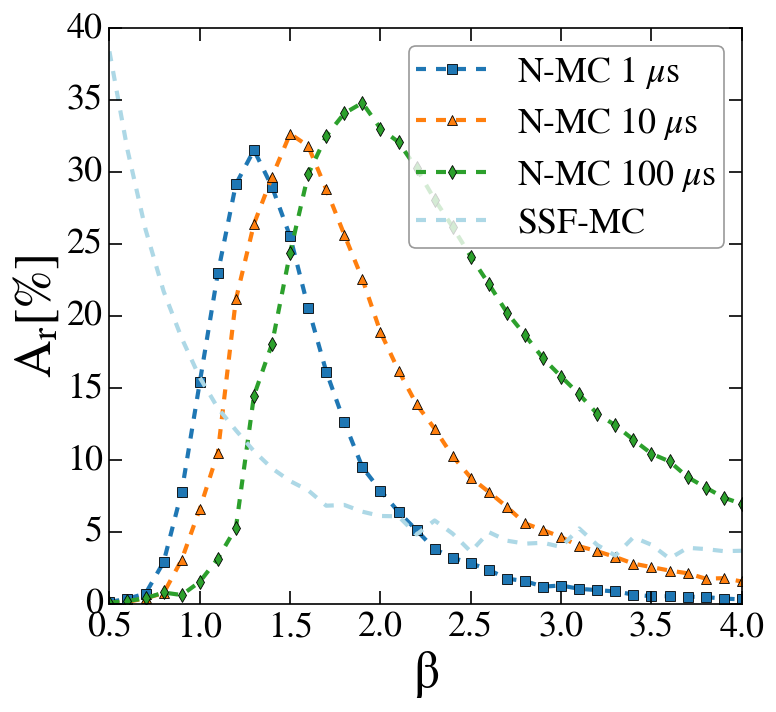

In [63]:
labels_ar = [r"N-MC 1 $\mu$s", r"N-MC 10 $\mu$s", r"N-MC 100 $\mu$s", "SSF-MC"]
line_style = ["--s", "--^", "--d", "--"]
color = ["tab:blue", "tab:orange", "tab:green", "lightblue"]

fig, ax = plt.subplots(1, 1, figsize=(6.8, 6))
plt_betas_ar(ax, acc_rates100, labels_ar, betas_100, line_style=line_style, color=color, save=True)


#### Histograms $E/N$ varying NNs

Histograms of $10^5$ configuration energies per spin $E/N$. We compare the generated configurations by NADE, MADE and PixelCNN with the training dataset.


PixelCNN
E: -1.1672147899994525 ± 0.00012536092484296657
min: -1.2210371482009983 (130 occurance(s))                                                                    (s))

NADE
E: -1.169423600850836 ± 0.00012186375444867048
min: -1.2210371482009983 (130 occurance(s))                                                                    (s))

MADE
E: -1.173334153976945 ± 0.00010188400008447856
min: -1.2210371482009983 (99 occurance(s))                                                                    (s))

100 $\mu$s eng
E: -1.175135307413431 ± 8.675419340016249e-05
min: -1.2210371482009983  (142 occurance(s))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


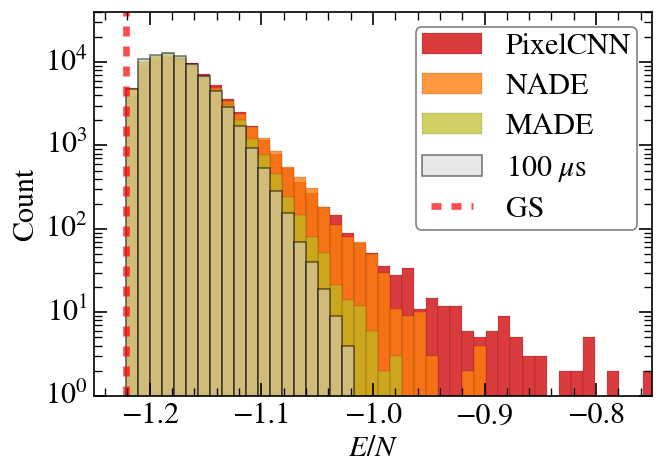

In [8]:
fig, ax1 = plt.subplots(1,1)
out1 = plot_hist(ax1, compare_nn, couplings_path_100spin, dwave_datasets_100[2], 
        ground_state=ground_state_100spin,
        colors=["tab:red", "tab:orange", "tab:olive"],
        labels=[r"PixelCNN", r"NADE", r"MADE", r"100 $\mu$s"], save=True, 
        xlim=[-1.25, -0.75], num_bins=60, order="F")
# out2 = plot_hist(ax2, compare_nn, couplings_path_100spin, dwave_datasets_100[2], 
#         ground_state=ground_state_100spin, 
#         labels=[r"PixelCNN", r"NADE", r"MADE", r"100 $\mu$s"], save=False, 
#         xlim=[-1.25, -0.75], num_bins=80, order="F")
#plt.show()


#### Histograms $E/N$ varying $t_A$

Histograms of $10^5$ configuration energies per spin $E/N$. The energy distribution for different annealing times show a clear shift to the lower-energy configuration when the annealing time increases Furthermore, with the longest annealing time D-Wave system sample configuration almost in the ground state (GS), even if the quantum annealer never reaches it. The data are obtained from the D-Wave quantum system after setting the annealing time, using several batches due the time constraints of a single D-Wave job. The horizontal red line is the ground state, computed using the McGroundstate solver.


1 $\mu$s
E: -1.1191339690673203 ± 0.00012771632692075338
min: -1.2210371482009983 (5 occurance(s))                                                                    (s))

10 $\mu$s
E: -1.1474951860175366 ± 0.00010770073347614297
min: -1.2210371482009983 (32 occurance(s))                                                                    (s))

100 $\mu$s eng
E: -1.175135307413431 ± 8.675419340016249e-05
min: -1.2210371482009983  (142 occurance(s))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


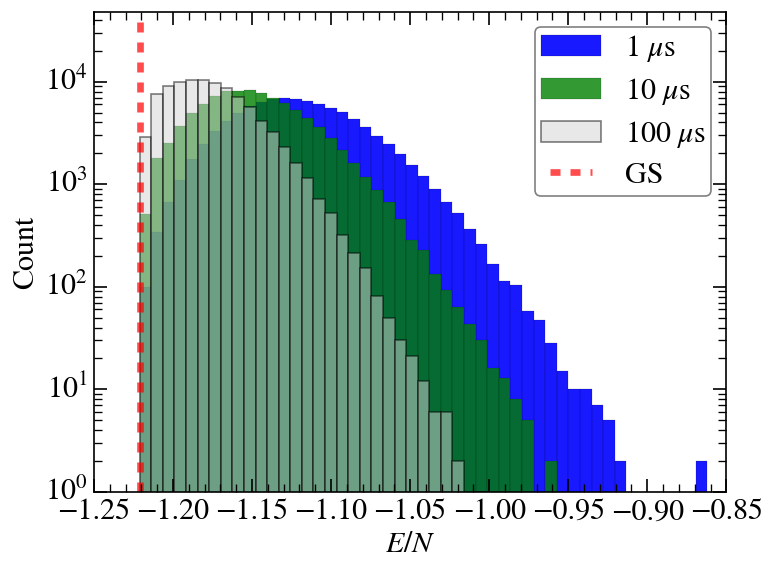

In [68]:
fig, ax2 = plt.subplots(1,1, figsize=(6.8, 5.))
out2 = plot_hist(ax2, dwave_datasets_100[:2], couplings_path_100spin, dwave_datasets_100[2], 
        ground_state=ground_state_100spin, 
        labels=[r"1 $\mu$s", r"10 $\mu$s", r"100 $\mu$s"], save=True, order="F")


#### $E/N$ as a function of $\beta$ with Neural Monte Carlo

The Neural Monte Carlo simulations (N-MCMC) for 100 spins, varying the dataset used during training. Increasing the annealing time in the D-Wave machine moves the sample to the lower energies, thus we observe a mismatch at lower $\beta$. The horizontal red line is the ground state energy, computed using the McGroundstate solver.

In [86]:
betas_100spin = np.linspace(0.8, 2.2, num=8)
skip_neural = 2000
skip_single = 2000

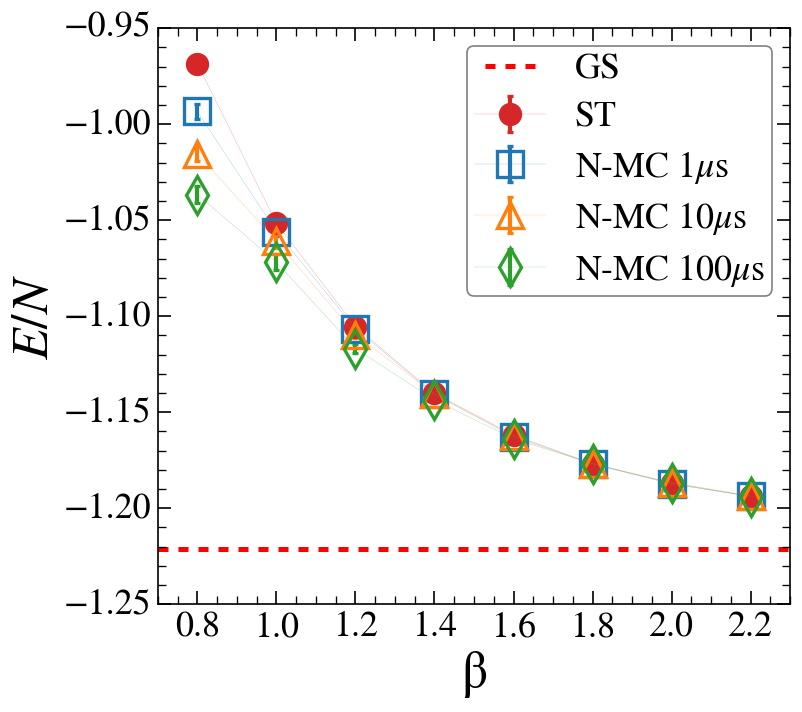

In [87]:
fig = plt.figure(figsize=(6.8, 6.))

plt.errorbar(betas_100spin, engs_single_100spins[...,skip_single:].mean(-1), 
        yerr=block_std(engs_single_100spins, 2000), elinewidth=2.5, linewidth=.1, marker='o', 
        color='tab:red', mec='tab:red', fillstyle='full', markersize=12, markeredgewidth=2, capsize=2, label=r"ST")
plt.errorbar(betas_100spin, engs_1mu[...,skip_neural:].mean(-1), yerr=block_std(engs_1mu, skip_neural),
        elinewidth=2.5, linewidth=.1, marker='s', fillstyle='none', markersize=16, 
        color='tab:blue', mec='tab:blue', markeredgewidth=2, capsize=2, label=r"N-MC $1\mu$s")
plt.errorbar(betas_100spin, engs_10mu[...,skip_neural:].mean(-1), yerr=block_std(engs_10mu, skip_neural), 
        elinewidth=2.5, linewidth=.1, marker='^', fillstyle='none', markersize=16, 
        color='tab:orange', mec='tab:orange', markeredgewidth=2, capsize=2, label=r"N-MC $10\mu$s")
plt.errorbar(betas_100spin, engs_100mu[...,skip_neural:].mean(-1), yerr=block_std(engs_100mu, skip_neural), 
        elinewidth=2.5, linewidth=.1, marker='d', fillstyle='none', markersize=16, 
        color='tab:green', mec='tab:green', markeredgewidth=2, capsize=2, label=r"N-MC $100\mu$s")

plt.hlines(ground_state_100spin, xmin=0.6, xmax=2.4, colors='red', linestyles='dashed', 
        label="GS", linewidth=3)

plt.xlim(0.7, 2.3)
#plt.ylim(-0.76, -0.68) 

plt.ylabel(r"$E/N$")
plt.xlabel(r"$\mathrm{\beta}$")

plt.legend()

plt.savefig(
    "images/energy-beta_neural100.png",
    edgecolor='white', 
    bbox_inches='tight', 
    transparent=False
)
plt.savefig(
    "images/energy-beta_neural100.eps",
    edgecolor="white",
    bbox_inches="tight",
    format="eps",
)


#### $E/N$ as a function of $\beta$ with Hybrid Monte Carlo

The Neural Monte Carlo simulations (N-MCMC) for 100 spins, but using a hybrid training dataset. The training dataset is made half using D-Wave data and half adding sample from a single spin-flip MCMC at $\beta=0.5$. The horizontal red line is the ground state energy, computed using the McGroundstate solver.

In [68]:
betas_100spin = np.linspace(0.8, 2.2, num=8)
skip_neural = 2000
skip_hybrid = 2000
skip_single = 2000

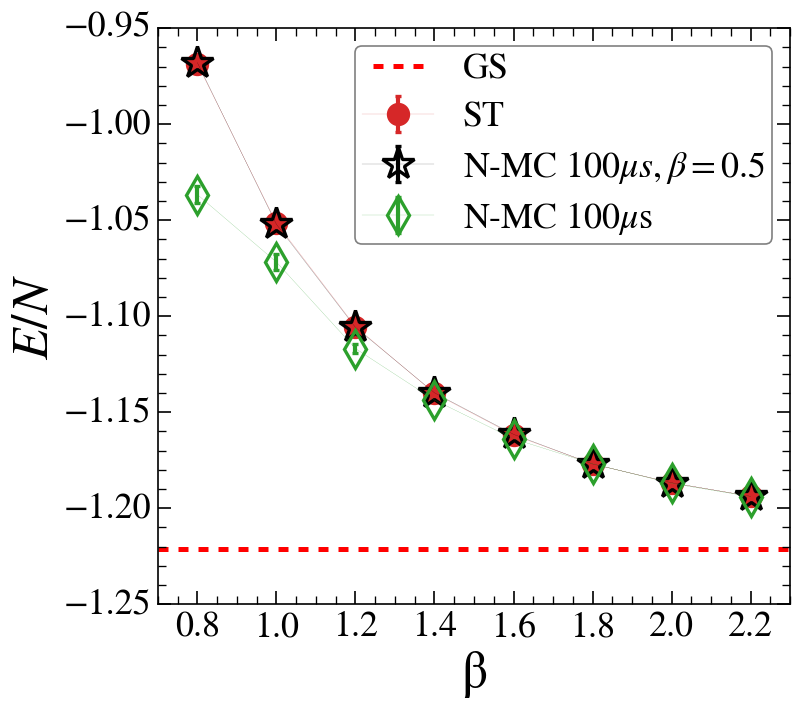

In [69]:
fig = plt.figure(figsize=(6.8, 6.))

plt.errorbar(betas_100spin, engs_single_100spins[...,skip_single:].mean(-1), 
        yerr=block_std(engs_single_100spins, 2000), elinewidth=2.5, linewidth=.1, marker='o', 
        color='tab:red', mec='tab:red', fillstyle='full', markersize=12, markeredgewidth=2, capsize=2, label=r"ST")
plt.errorbar(betas_100spin, engs_hybrid_100spins[...,skip_hybrid:].mean(-1), 
        yerr=block_std(engs_hybrid_100spins, skip_hybrid), elinewidth=2.5, linewidth=.1, marker='*', 
        fillstyle='none', markersize=20, color='black', mec='black', markeredgewidth=2, capsize=2, 
        label=r"N-MC $100\mu s, \beta=0.5$")
plt.errorbar(betas_100spin, engs_100mu[...,skip_neural:].mean(-1), yerr=block_std(engs_100mu, skip_neural), 
        elinewidth=2.5, linewidth=.1, marker='d', fillstyle='none', markersize=16, 
        color='tab:green', mec='tab:green', markeredgewidth=2, capsize=2, label=r"N-MC $100\mu$s")

plt.hlines(ground_state_100spin, xmin=0.6, xmax=2.4, colors='red', linestyles='dashed', 
        label="GS", linewidth=3)

plt.xlim(0.7, 2.3)
#plt.ylim(-0.76, -0.68) 

plt.ylabel(r"$E/N$")
plt.xlabel(r"$\mathrm{\beta}$")

plt.legend()

plt.savefig(
    "images/energy-beta_neural-hybrid.png",
    edgecolor='white', 
    bbox_inches='tight', 
    transparent=False
)
plt.savefig(
    "images/energy-beta_neural-hybrid.eps",
    edgecolor="white",
    bbox_inches="tight",
    format="eps",
)


### Ising model 484 spins and 1NN couplings

Here and in the following we focus on a fixed size and a particular disordered realization, which we saved in a .txt file.

In [2]:
spin_side = 22
spins = spin_side**2
couplings_path_1nn = "data/couplings/484spins-uniform-1nn.txt"
ground_state_1nn = -0.7550297905


#### Load the data


In [3]:
dwave_datasets_1nn = [
    "data/datasets/484-1nn-uniform-1mus/train-484spins-1nn-uniform-1mus.npy",
    "data/datasets/484-1nn-uniform-10mus/train-484spins-1nn-uniform-10mus.npy",
    "data/datasets/484-1nn-uniform-100mus/train-484spins-1nn-uniform-100mus.npy"
    ]

In [4]:
made_data_1nn = [
"data/generated/sample-1000000_size-484_2022-01-28_15-48-44.npz", # 1mus 1nn
"data/generated/sample-1000000_size-484_2022-01-28_15-50-01.npz", # 10mus 1nn
"data/generated/sample-1000000_size-484_2022-02-10_11-48-45.npz", # 100mus 1nn
"data/generated/sample-1000000_size-484_2022-05-10_23-59-33.npz", # 1-10-100mus 1nn
"data/generated/sample-1000000_size-484_2022-02-10_15-28-37.npz", # 1<beta<2.5 1nn
"data/generated/sample-1000000_size-484_2022-06-07_18-57-46.npz"  # 100mus&1<beta<2.5 1nn
]

labels_1nn = [r"1 $\mu$s",r"10 $\mu$s", r"100 $\mu$s", r"1-10-100 $\mu$s", 
          r"$1\leq\beta\leq2.5$", r"$100 \mu$s and $1\leq\beta\leq2.5$"
        ]

In [5]:
parent_path_1nn = "data/hybrid/1nn_100mus_betas10-40/"
hybrid_paths_1nn = sorted(os.listdir(parent_path_1nn))
hybrid_paths_1nn = [parent_path_1nn + path for path in hybrid_paths_1nn]
eng_seq_hybrid_1nn = [np.load(path)['energy'] / spin_side**2 for path in hybrid_paths_1nn]
eng_seq_hybrid_1nn = np.asarray(eng_seq_hybrid_1nn)

In [6]:
# seed for starting point of mcmc simulations
seeds = [12345, 23451, 34512, 45123, 51234]
betas = [2.0, 2.5, 3.0] # we use some significant temperatures only
single_engs_1nn = []
for seed in seeds:
    paths = []
    for beta in betas:
        paths.append(f"data/1nn-forpaper/484spins-seed{seed}-sample1000000-beta{str(beta)}.npy")
    single_engs_1nn.append(get_energy(22, paths, couplings_path_1nn))
single_engs_1nn = np.asarray(single_engs_1nn)

In [7]:
# load all the energies for beta in [1,5]
single_engs_long_1nn = np.load("data/energy_beta10-50_1nn-uniform.npy")

In [8]:
betas_neural = np.linspace(1.5, 4, 26)
betas_foreng = np.linspace(1., 4, 31)

single_block_size = 6000
hybrid_block_size = 4000
neural_block_size = 2000
skip_single = 50000
skip_hybrid = 20000
skip_neural = 0

single_error_1nn = get_errorbar(single_engs_long_1nn, single_block_size, skip_single)


#### Acceptance Rate vs $t_A$

Acceptance rate, i.e. $A_{\sigma, \sigma'}$ in the Neural Markov Chain Monte Carlo (N-MCMC) guided by the Autoregressive Neural Network (ANN), at different $\beta$. the ANN is trained using the D-Wave dataset with annealing time $t_A=100 \mu s$.
 

In [ ]:
betas_1nn = np.linspace(0.1, 5, num=50)

acc_rates = []
for i, dataset in enumerate(made_data_1nn):
    acc_rate = []
    if i > 2:
        continue
    for beta in betas_1nn:
        _, _, ar = neural_mcmc(beta, 100000, dataset, couplings_path_1nn, "made", disable_bar=False)
        acc_rate.append(ar)
    acc_rates.append(acc_rate)

# remove the labels of the dataset  
# that we didn't use
labels_ar = []
for i, label in enumerate(labels_1nn):
    if i>2:
        continue
    labels_ar.append(label)

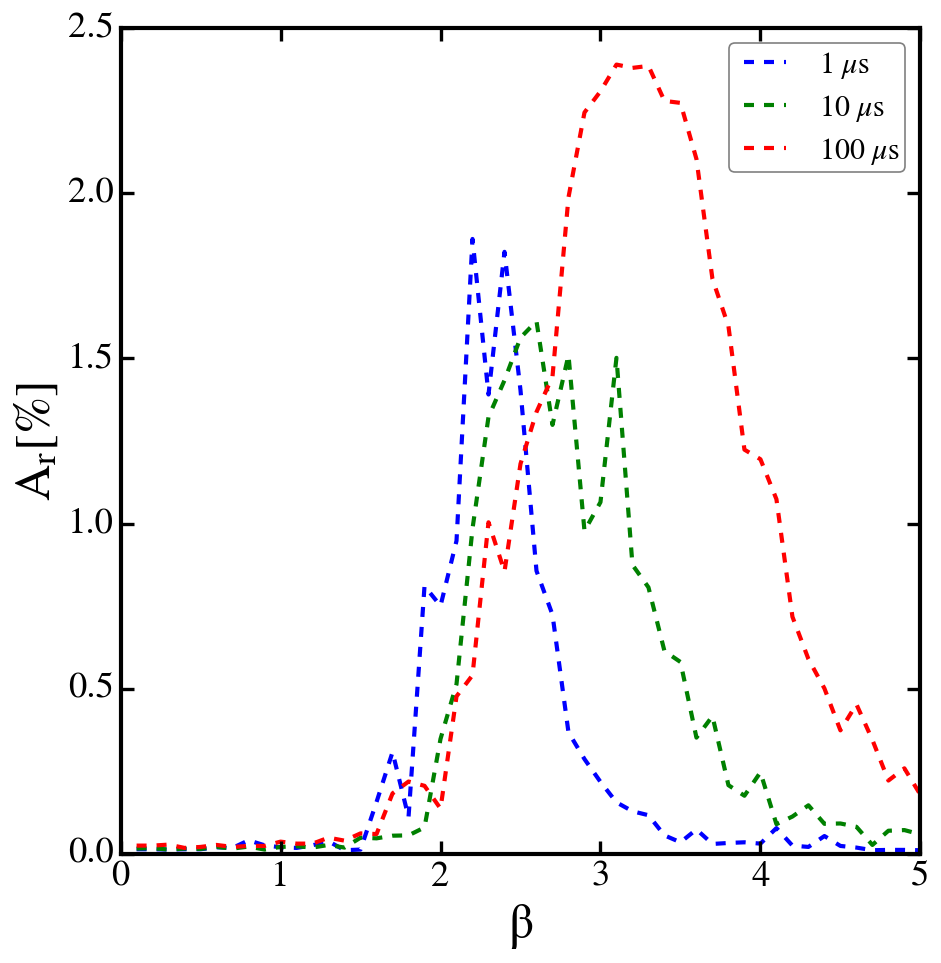

In [110]:
plt_betas_ar(acc_rates, labels_ar, betas_1nn, save=False)


#### Energy vs Steps

Average energy per spin $E/N$ as a function of Monte Carlo steps. The Hybrid Markov Chain Monte Carlo (H-MCMC) thermalizes much faster w.r.t the single spin-flip MCMC. Here for the single spin-flip MCMC, we considered a step $\tau$ as a single sweep, for the H-MCMC a step is composed by a sweep and a neural proposal. The horizontal red line is the ground state energy, computed using the McGroundstate solver.

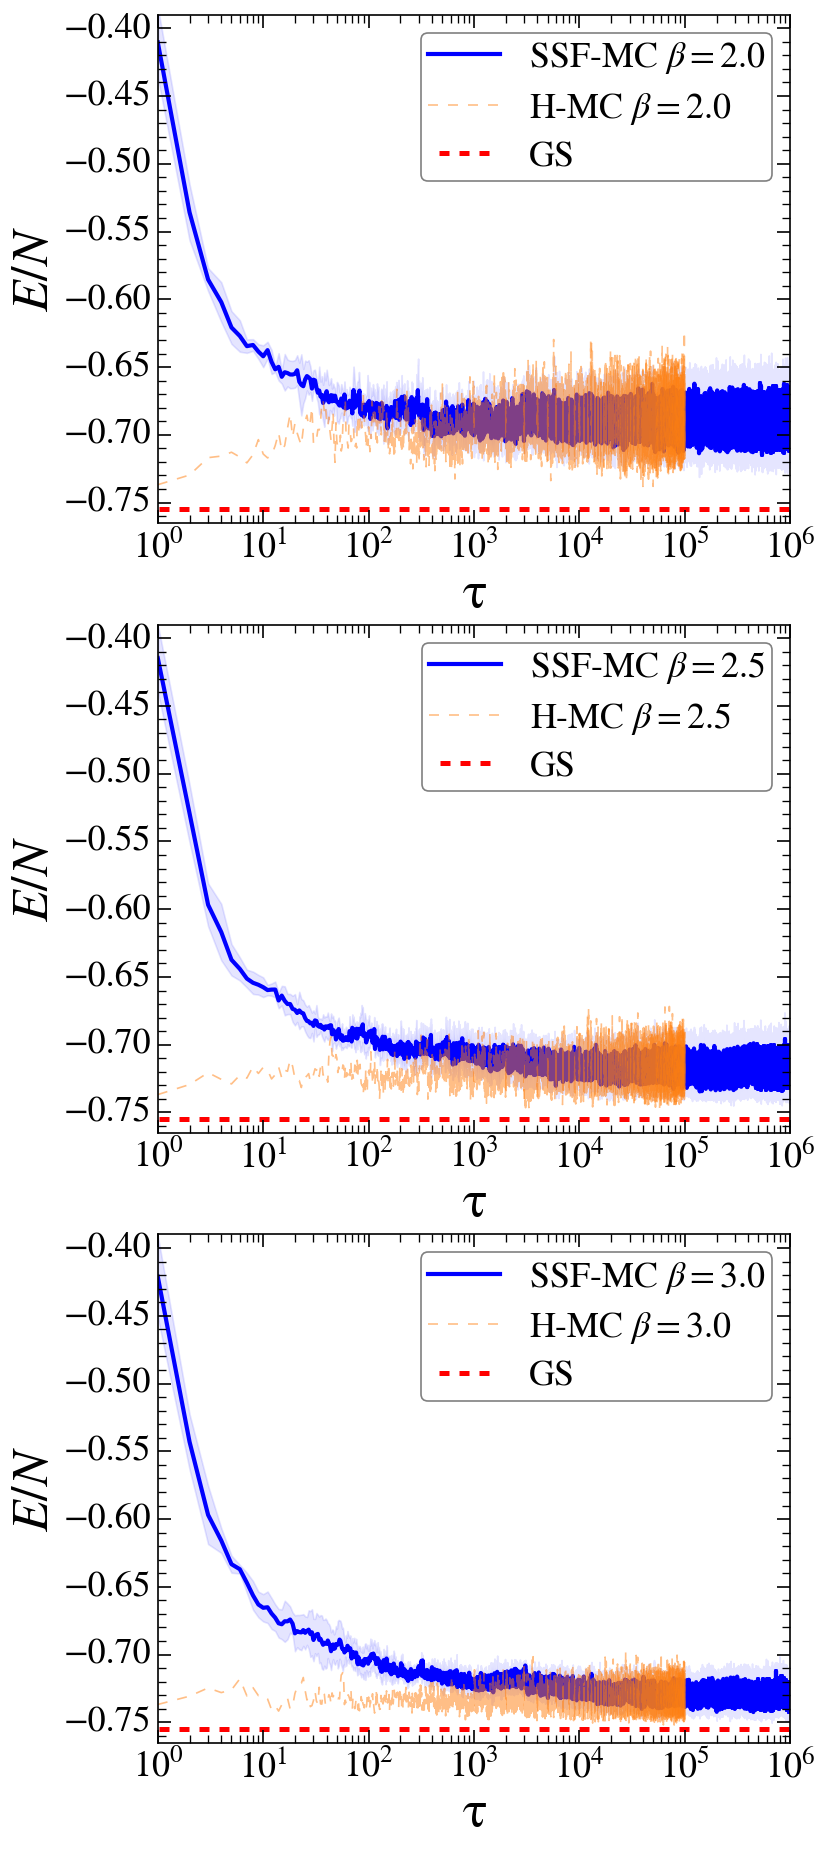

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6.8, 18.))
ax = (ax1, ax2, ax3)

idxs = [10, 15, 20] # valid index in hybrid-MCMC

for i, idx in enumerate(idxs):
    if i!=2:
        pass
    plt_eng_step(ax[i], single_engs_1nn[:,i], eng_seq_hybrid_1nn[idx, :100000], 
        rf"SSF-MC $\beta={betas[i]}$", rf"H-MC $\beta={betas[i]}$",  
        ground_state=ground_state_1nn, xlim=(1, 1000000), 
        ylim=(ground_state_1nn - 0.01, -0.39), save=False)


#### Autocorrelation vs MCMC Steps (log scale)

 The plot shows the autocorrelations $c(\tau)$ in log-scale measured for different simulations, single spin-flip and hybrid, both performed at three challenging temperatures. On one hand, the correlations of the single spin-flip MCMC increase as the $\beta$ increases, on the other hand, the H-MCMC correlations are stably one or two orders of magnitude lower. In the $x$ axis $\tau$ is a sweep for MCMC and a sweep plus a neural step for H-MCMC.

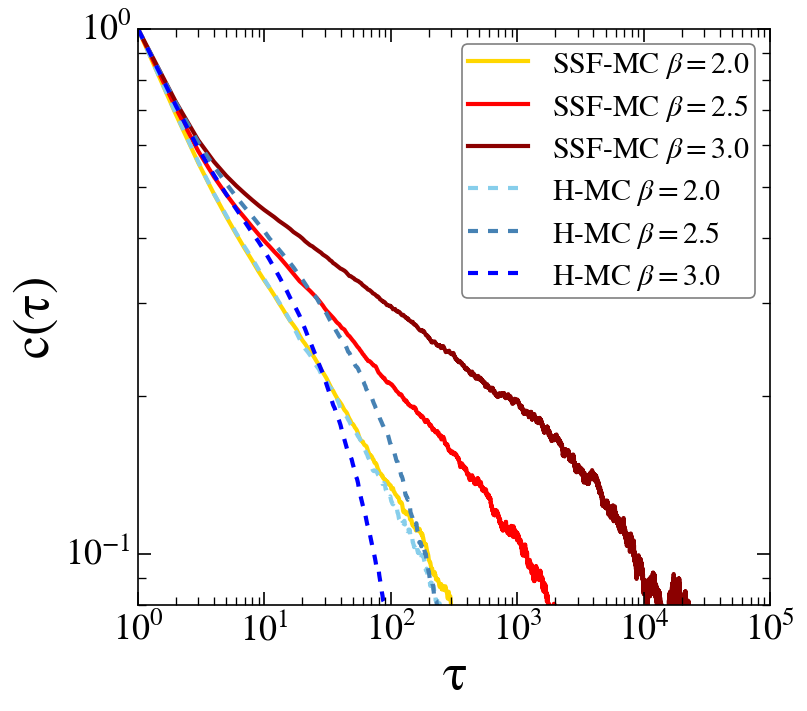

In [78]:
skip=100000 #skip the first samples, used for thermalization
idxs = [10, 15, 20] # valid index in hybrid-MCMC

ac_betas_1nn = []
ac_hybrid = []
for i, idx in enumerate(idxs):
    ac_betas_1nn.append(acf(single_engs_1nn[0,i,skip:], nlags=50000, fft=True))
    ac_hybrid.append(acf(eng_seq_hybrid_1nn[idx], nlags=50000, fft=True))

plt_acf(
    [ac_betas_1nn[0], ac_betas_1nn[1], ac_betas_1nn[2]], 
    [r"SSF-MC $\beta=2.0$", r"SSF-MC $\beta=2.5$", r"SSF-MC $\beta=3.0$"], 
    [ac_hybrid[0], ac_hybrid[1], ac_hybrid[2]], 
    [r"H-MC $\beta=2.0$", r"H-MC $\beta=2.5$", r"H-MC $\beta=3.0$"], 
    ylim=(0.08, 1), 
    xlim=(1, 100000), 
    save=True,
)


#### Autocorrelation vs MCMC Steps

Autocorrelations as a function of Monte Carlo steps. For a single spin-flip Monte Carlo the correlation time increases when simulating lower temperature regime. At $\beta > 2$ they start to become infeasible. The fit has been done with a stretch exponential function, $\hat{c}(\tau) = a\exp([-(\tau/\tau^*)^\alpha])$, where $a, \tau^* \text{ and } \alpha$ are fitted parameters.

$\beta=2.0$ a=1.0335148840356845 tau*=5.664998129692427 alpha=0.2435722132155389
$\beta=2.5$ a=1.0387053738891863 tau*=8.471841607387688 alpha=0.17580772249579424
$\beta=3.0$ a=1.0599455821317434 tau*=16.63103869740536 alpha=0.1311628716108515


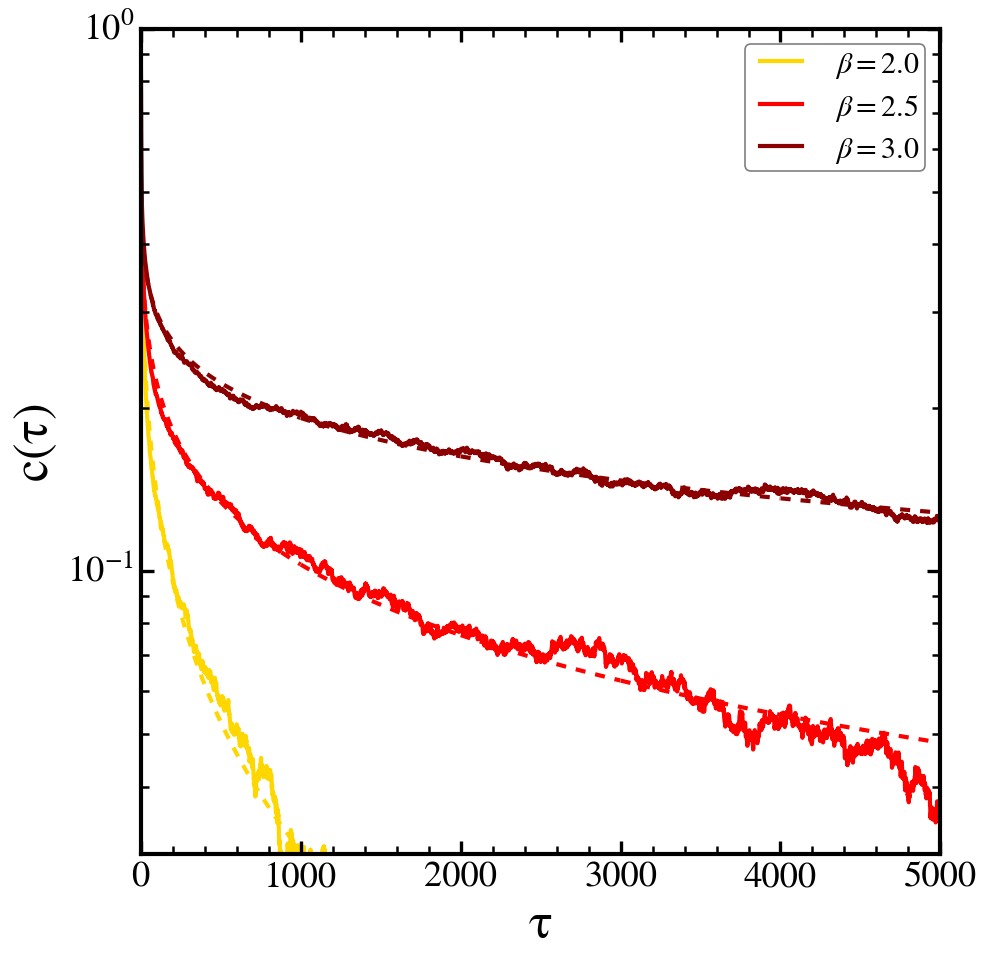

In [54]:
label1 = [rf"$\beta={beta}$" for beta in betas]

plt_acf(ac_betas_1nn, label1, log_scale=False, xlim=(0, 5000), ylim=(0.03, 1), fit=True, save=True)


#### Histograms $E/N$ varying $t_A$

Histograms of $4 \cdot 10^5$ configuration energies per spin $E/N$. The energy distribution for different annealing time $t_A$ show a clear shift to the lower-energy configuration when the annealing time increases Furthermore, with the longest annealing time D-Wave system sample configuration almost in the ground state (GS), even if the quantum annealer never reaches it. The data are obtained from the D-Wave quantum system after setting the annealing time, using several batches due the time constraints of a single D-Wave job. The horizontal red line is the ground state, computed using the McGroundstate solver.


1 $\mu$s
E: -0.7021283618736106 ± 2.090670165483138e-05
min: -0.7433134379818167 (1 occurance(s))                                                                    (s))

10 $\mu$s
E: -0.7211725082190017 ± 1.4668936649154495e-05
min: -0.7511945731648754 (1 occurance(s))                                                                    (s))

100 $\mu$s eng
E: -0.7320812975269184 ± 1.1506537873615045e-05
min: -0.7534729061392554  (1 occurance(s))


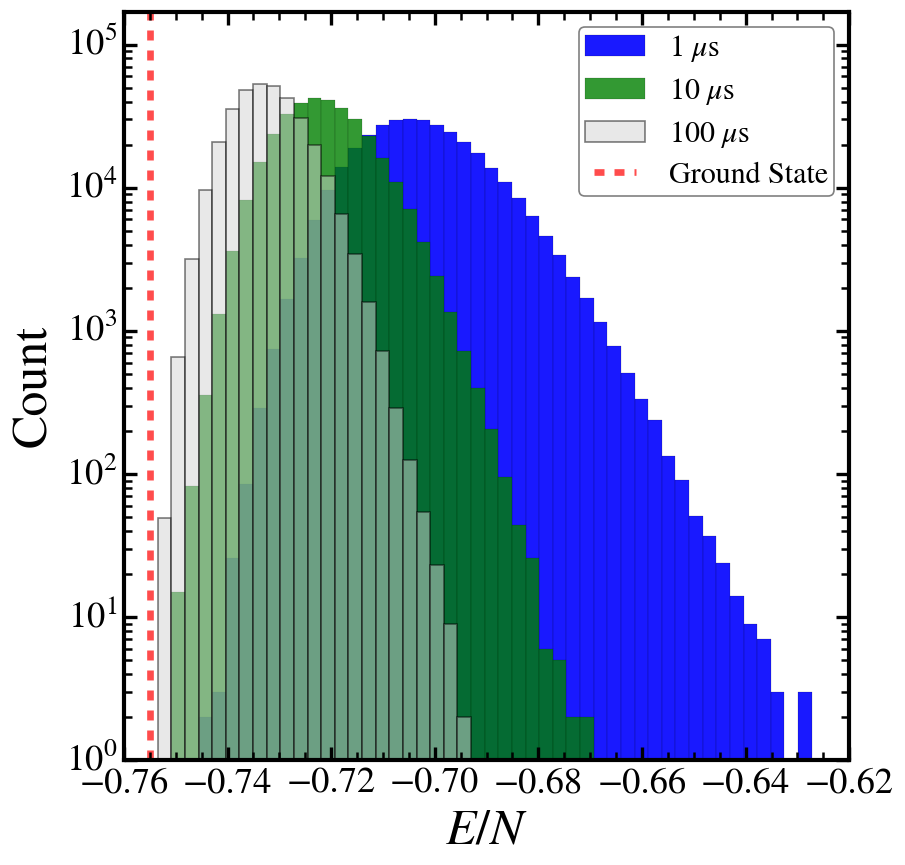

In [7]:
plot_hist(dwave_datasets_1nn[:2], couplings_path_1nn, dwave_datasets_1nn[2], 
        ground_state=ground_state_1nn, 
        labels=[r"1 $\mu$s", r"10 $\mu$s", r"100 $\mu$s"], save=False)


#### $E/N$ as a function of $\beta$



##### Neural Monte Carlo

The Neural Monte Carlo simulations (N-MCMC) for 484 spins becomes hard to perform due the D-Wave bias. We can only reconstruct the thermodynamics at higher β since the D-Wave sample are shifted to the lower energies. The horizontal red line is the ground state energy, computed using the McGroundstate solver.

In [ ]:
neural_eng_1nn = []
for beta in betas_neural:
    _, eng, _ = neural_mcmc(beta, 10000, made_data_1nn[2], couplings_path_1nn, 
                            model='made', disable_bar=True)
    neural_eng_1nn.append(eng/484)
neural_eng_1nn = np.asarray(neural_eng_1nn)

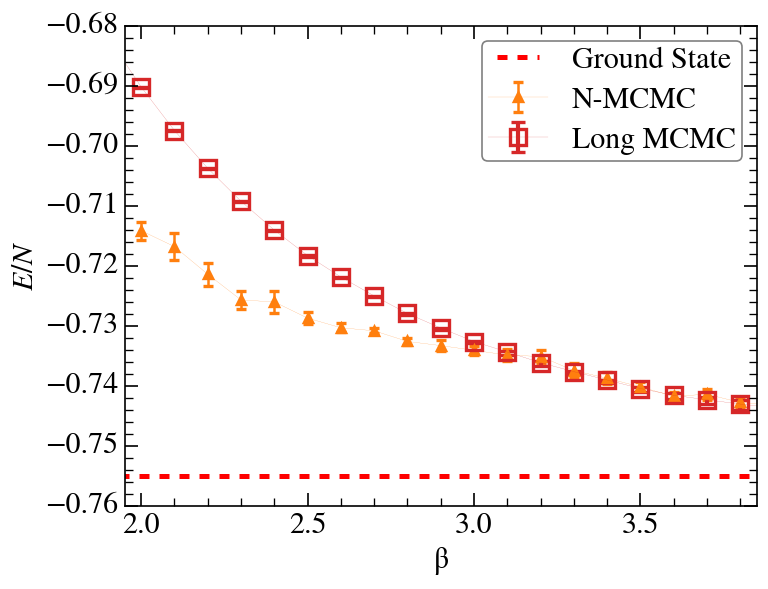

In [16]:
plt.errorbar(betas_neural, neural_eng_1nn.mean(1), yerr=block_std(neural_eng_1nn, 1000, skip=skip_neural), 
            elinewidth=1.5, linewidth=.1, marker='^', color='tab:orange', fillstyle='full', markersize=5, 
            markeredgewidth=2, mec='tab:orange', label=r"N-MC")
plt.errorbar(betas_foreng, (single_engs_long_1nn[..., skip_single:].mean(axis=2).mean(axis=0).tolist()[:-10]), 
            yerr=single_error_1nn[:, :-10], elinewidth=2.5, linewidth=.1, marker='s', color='tab:red', 
            fillstyle='none', markersize=10, markeredgewidth=2, capsize=4, label=r"SSF-MC")


plt.hlines(ground_state_1nn, xmin=0.4, xmax=4.4, colors='red', linestyles='dashed', 
           label="Ground State", linewidth=3)


plt.xlim(1.95, 3.85)
plt.ylim(-0.76, -0.68) 

plt.ylabel(r"$E/N$")
plt.xlabel(r"$\mathrm{\beta}$")

plt.legend()

plt.savefig(
    "images/energy-beta_neural.png",
    edgecolor='white', 
    bbox_inches='tight', 
    transparent=False
)
plt.savefig(
    "images/energy-beta_neural.eps",
    edgecolor="white",
    bbox_inches="tight",
    format="eps",
)


##### Hybrid Monte Carlo

The new hybrid Monte Carlo (H-MCMC) gives good results for every temperature, without changing the dataset. In the plot above we used a D-Wave dataset obtained at annealing time $T_{a} = 100 \mu s$ and we focused in the range $\beta \in [1,4]$, which is already a challenging temperature for a single spin-flip MCMC. The horizontal red line is the ground state energy, computed using the McGroundstate solver.

In [ ]:
plt.errorbar(betas_100spin, engs_single_100spins[...,skip_single:].mean(-1), 
        yerr=block_std(engs_single_100spins, 2000), elinewidth=2.5, linewidth=.1, marker='o', 
        color='tab:red', mec='tab:red', fillstyle='full', markersize=12, markeredgewidth=2, 
        capsize=2, label=r"ST")
plt.errorbar(betas_100spin, engs_1mu[...,skip_neural:].mean(-1), yerr=block_std(engs_1mu, skip_neural),
        elinewidth=2.5, linewidth=.1, marker='s', fillstyle='none', markersize=16, 
        color='tab:blue', mec='tab:blue', markeredgewidth=2, capsize=2, label=r"N-MC $1\mu$s")

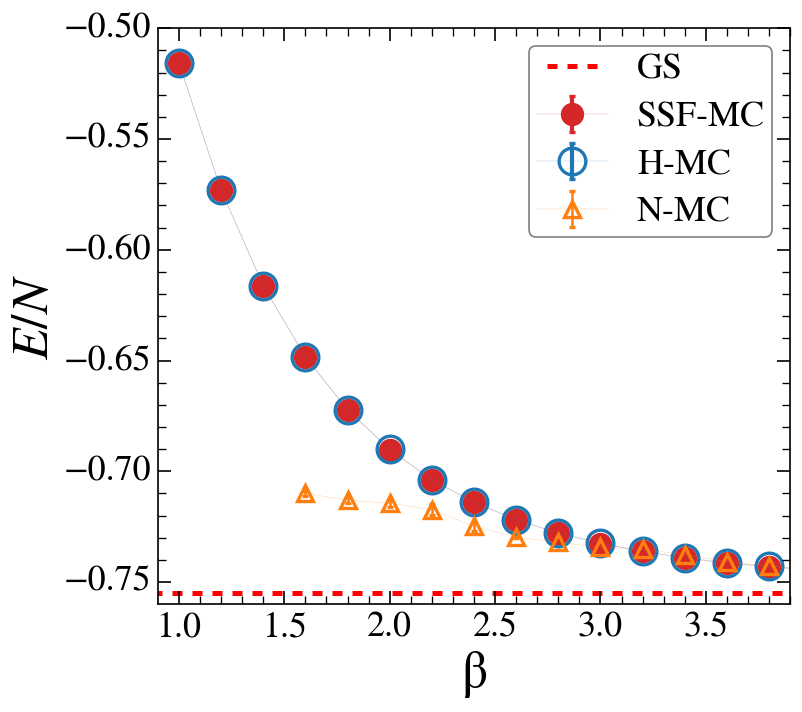

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(6.8,6))

plt.errorbar(betas_foreng[::2],
            (single_engs_long_1nn[..., skip_single:].mean(axis=2).mean(axis=0).tolist()[:-10][::2]), 
            yerr=single_error_1nn[:, :-10][1,::2], elinewidth=2.5, linewidth=.1, marker='o', 
            color='tab:red', mec='tab:red', fillstyle='full', markersize=12, markeredgewidth=2, 
            capsize=2, label=r"SSF-MC")
plt.errorbar(betas_foreng[::2], np.asarray(eng_seq_hybrid_1nn)[...,skip_hybrid:].mean(1)[::2], 
            yerr=block_std(eng_seq_hybrid_1nn, hybrid_block_size, skip=skip_hybrid)[::2], 
            elinewidth=2.5, linewidth=.1, marker='o', fillstyle='none', markersize=16, 
            color='tab:blue', mec='tab:blue', markeredgewidth=2, capsize=2, label=r"H-MC")
plt.errorbar(betas_neural[1::2], neural_eng_1nn.mean(1)[1::2], 
            yerr=block_std(neural_eng_1nn, 1000, skip=skip_neural)[1::2], 
            elinewidth=1.5, linewidth=.1, marker='^', color='tab:orange', fillstyle='none', 
            markersize=10, markeredgewidth=2, capsize=2, mec='tab:orange', label=r"N-MC")


plt.hlines(ground_state_1nn, xmin=0.4, xmax=4.4, colors='red', linestyles='dashed', 
           label="GS", linewidth=3)


plt.xlim(0.9, 3.9)
plt.ylim(-0.76, -0.5) 

plt.ylabel(r"$E/N$")
plt.xlabel(r"$\mathrm{\beta}$")

plt.legend()

plt.savefig(
    "images/energy-beta_hybrid.png",
    edgecolor='white', 
    bbox_inches='tight', 
    transparent=False
)
plt.savefig(
    "images/energy-beta_hybrid.eps",
    edgecolor="white",
    bbox_inches="tight",
    format="eps",
)


### D-Wave settings

The mapping between the Ising model of our Hamiltonian is not one to one into the Quantum Annealer, mainly because the two topologies could be different. Thus D-Wave uses an embedding procedure to assign each variable in the user's Hamiltonian to one or more qubits in its system. When more than one qubit is used to encode a variable, we have a chain. Every qubit in a chain has a strong coupling with its neighbors, therefore they act most of the time as a single variable. Nevertheless, sometimes some chains break and the qubits take on different values. In this case, the value attributed to the original variable is obtained through majority voting. 

To avoid the chain breaking, which leads to non-physical solutions, one can tune the `chains_strength` parameter in the D-Wave sampler. If the `chains_strength` is too large than the original problem couplings, the intra-chain couplings become predominant in the Hamiltonian, thus the annealer will optimize a wrong Hamiltonian. Otherwise, if the `chains_strength` is too small, several chain breaks can lead to configuration with lower energy than the original Hamiltonian's ground state. 

Moreover, the distribution used to sample the couplings plays an important role in the effectiveness of the annealing procedure. In the following we show some analysis on the D-Wave system.

In [11]:
dwave_path = "data"
rnds = ["uniform", "gaussian", "binary"]
strengths = np.linspace(0.5, 4, 15)

# uniform-couplings properties
uniform_ground_state = -0.7550297905
uniform_dwave_default = 1.5828847157168355
# gaussian-couplings properties
gaussian_ground_state = -1.2769078779999998 
gaussian_dwave_default = 2.7174204926999237
# binary-couplings properties
binary_ground_state = -1.3636342975206612
binary_dwave_default =  2.7629798143572195

In [12]:
engs = {"uniform": [], "gaussian": [], "binary": [],}
for rnd in rnds:
    for strength in strengths:
        try:
            eng = np.load(f"{dwave_path}/sweep_chains_{rnd}/dwave-engs_{strength}.npy")
        except:
            pass
        engs[rnd].append(eng)
    engs[rnd] = np.asarray(engs[rnd])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


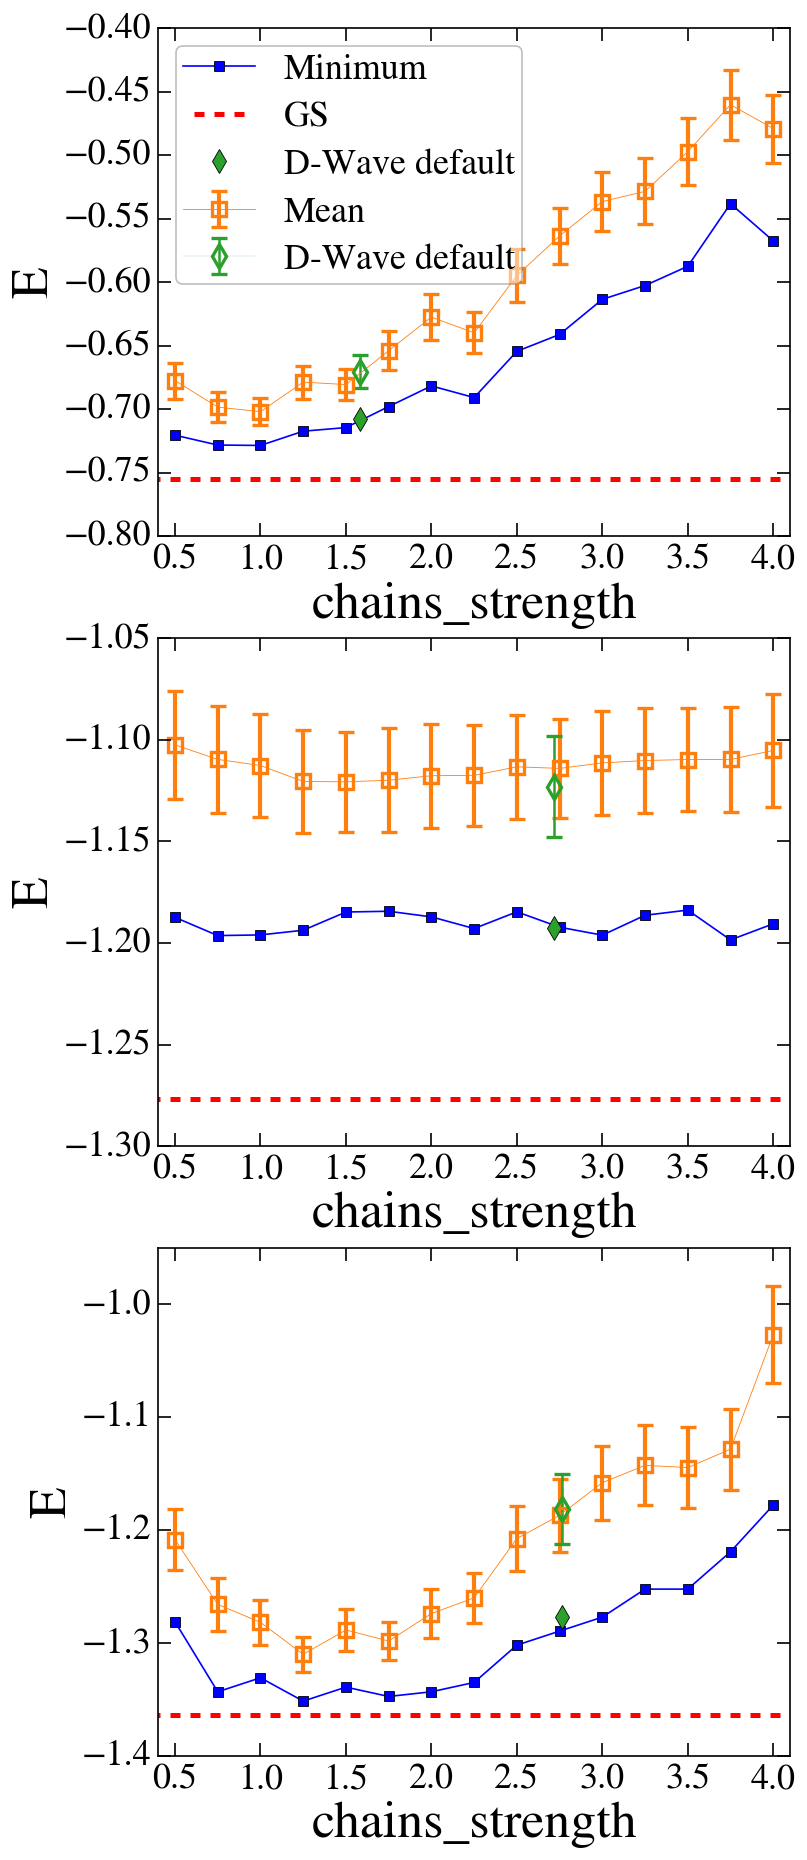

In [15]:
ground_states = [uniform_ground_state, gaussian_ground_state, binary_ground_state]
dwave_defaults = [uniform_dwave_default, gaussian_dwave_default, binary_dwave_default]
titles = ["Uniform", "Gaussian", "Binary"]
legends = [True, False, False]

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6.8, 18))
ax=(ax1, ax2, ax3)
for i, rnd in enumerate(rnds):
    plt_eng_chains(ax[i], engs[rnd], strengths, ground_state=ground_states[i],
                   title=titles[i], dwave_default=dwave_defaults[i], legend=legends[i],
                   save=True)
plt.savefig(f"images/chains_all.png")
plt.show()


### Ising model 484 spins and 3NN couplings

Here and in the following we focus on a fixed size and a particular disordered realization, which we saved in a .txt.

In [16]:
spin_side = 22
spins = spin_side**2
couplings_path_3nn = "data/couplings/484spins-uniform-3nn.txt"
ground_state_3nn = -1.0982 


#### Load Data


In [17]:
dwave_datasets_3nn = [
    "data/datasets/484-3nn-uniform-1mus/train-484spins-3nn-uniform-1mus.npy",
    "data/datasets/484-3nn-uniform-10mus/train-484spins-3nn-uniform-10mus.npy",
    "data/datasets/484-3nn-uniform-100mus/train-484spins-3nn-uniform-100mus.npy",
    ]

In [18]:
made_data_3nn = [
"data/generated/sample-500000_size-484_2022-03-01_11-09-49.npz", # 1mus 3nn
"data/generated/sample-1000000_size-484_2022-03-01_11-48-11.npz", # 10mus 3nn
"data/generated/sample-1000000_size-484_2022-03-01_11-50-00.npz", # 100mus 3nn
"data/generated/sample-1000000_size-484_2022-05-10_23-59-33.npz", # 1-10-100mus 3nn
"data/generated/sample-1000000_size-484_2022-02-10_15-28-37.npz", # 1<beta<2.5 3nn
"data/generated/sample-1000000_size-484_2022-02-10_17-00-33.npz" # 100mus and 1<beta<2.5 3nn
]

labels_3nn = [r"1 $\mu$s",r"10 $\mu$s", r"100 $\mu$s", r"1-10-100 $\mu$s", 
            r"$1\leq\beta\leq2.5$", r"$100 \mu$s and $1\leq\beta\leq2.5$"
            ]

In [19]:
betas_single_3nn = np.linspace(1, 2.4, num=15)
betas_single_3nn = np.append(betas_single_3nn, np.linspace(2.75, 5, num=10))
betas_single_3nn = np.append([0.5, 0.75], betas_single_3nn)

single_engs_long_3nn = np.load("data/MCMC_single/energies-MCMC-4843nn.npy")

In [20]:
betas_hybrid_3nn = np.linspace(1, 4, 31)
betas_hybrid_3nn_all = np.append(betas_hybrid_3nn, 
        [4.25, 4.25, 4.5, 4.75, 4.75, 5., 5.5, 5.5, 6., 6.5, 6.5, 7., 7.5, 7.5, 
        8., 8.5, 8.5, 9., 9.5, 9.5, 10.])
betas_hybrid_3nn = np.append(betas_hybrid_3nn, 
        [4.25, 4.5, 4.75, 5., 5.5, 6., 6.5, 7., 7.5, 8., 8.5, 9., 9.5, 10.])


parent_path = "data/hybrid/3nn_100mus_betas10-50/"

hybrid_paths = sorted(os.listdir(parent_path))
hybrid_paths = [parent_path + path for path in hybrid_paths]

eng_seq_hybrid_3nn = [np.load(path)['energy'] / spin_side**2 for path in hybrid_paths]
eng_seq_hybrid_3nn = np.asarray(eng_seq_hybrid_3nn)

In [21]:
# temperature for parallel tempering
parallel_num_temp = 40

T = np.zeros(parallel_num_temp)
energies_parallel_3nn = []

for i in range(parallel_num_temp):
    try:
        with open('data/PT-MCMC/484-3nn-20220628/timeseries2d-ising_T'+str(i)+'.json') as file:
            timeseries = json.load(file)
    except json.JSONDecodeError:
        print('failed for file '+str(i))
        raise

    T[i] = 1./timeseries[0]['beta']
    energies_parallel_3nn.append(
        np.array([timeseries[t]['energy'] for t in range(len(timeseries))]) / spin_side**2
        )
    # magnetisations = np.array([timeseries[t]['magnetisation'] for t in range(len(timeseries))]) / spin_side**2
    
energies_parallel_3nn = np.asarray(energies_parallel_3nn)

In [22]:
# temperature for parallel tempering
parallel_num_temp_corr = 22

T_forcorr = np.zeros(parallel_num_temp_corr)
energies_parallel_3nn_forcorr = []

for i in range(parallel_num_temp_corr):
    try:
        with open('data/PT-MCMC/484-3nn-20220703-TEST/timeseries2d-ising_T'+str(i)+'.json') as file:
            timeseries = json.load(file)
    except json.JSONDecodeError:
        print('failed for file '+str(i))
        raise

    T_forcorr[i] = 1./timeseries[0]['beta']
    energies_parallel_3nn_forcorr.append(
        np.array([timeseries[t]['energy'] for t in range(len(timeseries))]) / spin_side**2
        )
    # magnetisations = np.array([timeseries[t]['magnetisation'] for t in range(len(timeseries))]) / spin_side**2
    
energies_parallel_3nn_forcorr = np.asarray(energies_parallel_3nn_forcorr)

In [23]:
betas_1sweep = [1.0, 1.1, 1.2]

paths_1sweep = []
for beta in betas_1sweep:
    paths_1sweep.append(f"data/3nn-forpaper/484spins-seed12345-sample11000000-sweeps1-beta{beta}.npy")

engs_1sweep = get_energy(22, paths_1sweep, couplings_path_3nn)

engs_1sweep = [eng[:999999] for eng in engs_1sweep]
engs_1sweep = np.asarray(engs_1sweep)

In [40]:
# energy SSF-MCMC 1 sweeps for beta=4
seed_1sweep = [12345, 23451, 34512, 45123, 51234]

paths_1sweep_beta4 = []
for seed in seed_1sweep:
    paths_1sweep_beta4.append(
        f"data/20220924_ssf-mcmc/484spins-seed{seed}-sample1000000-sweeps1-beta4.0.npy"
        )

engs_1sweep_beta4 = get_energy(22, paths_1sweep_beta4, couplings_path_3nn)

engs_1sweep_beta4= [eng for eng in engs_1sweep_beta4]
engs_1sweep_beta4 = np.asarray(engs_1sweep_beta4)


#### Acceptance Rate vs $t_A$

Acceptance rate, i.e. $A_{\sigma, \sigma'}$ in the Neural Markov Chain Monte Carlo (N-MCMC) guided by the Autoregressive Neural Network (ANN), at different $\beta$. the ANN is trained using the D-Wave dataset with annealing time $t_A=100 \mu s$.

In [ ]:
betas_3nn = np.linspace(0.5, 10, num=50)

acc_rates_3nn = []
for i, dataset in enumerate(made_data_3nn):
    acc_rate_3nn = []
    if i > 2:
        continue
    for beta in betas_3nn:
        _, _, ar = neural_mcmc(beta, 100000, dataset, couplings_path_3nn, "made", disable_bar=True)
        acc_rate_3nn.append(ar)
    acc_rates_3nn.append(acc_rate_3nn)

# remove the labels of the dataset  
# that we didn't use
labels_ar = []
for i, label in enumerate(labels_3nn):
    if i>2:
        continue
    labels_ar.append(label)

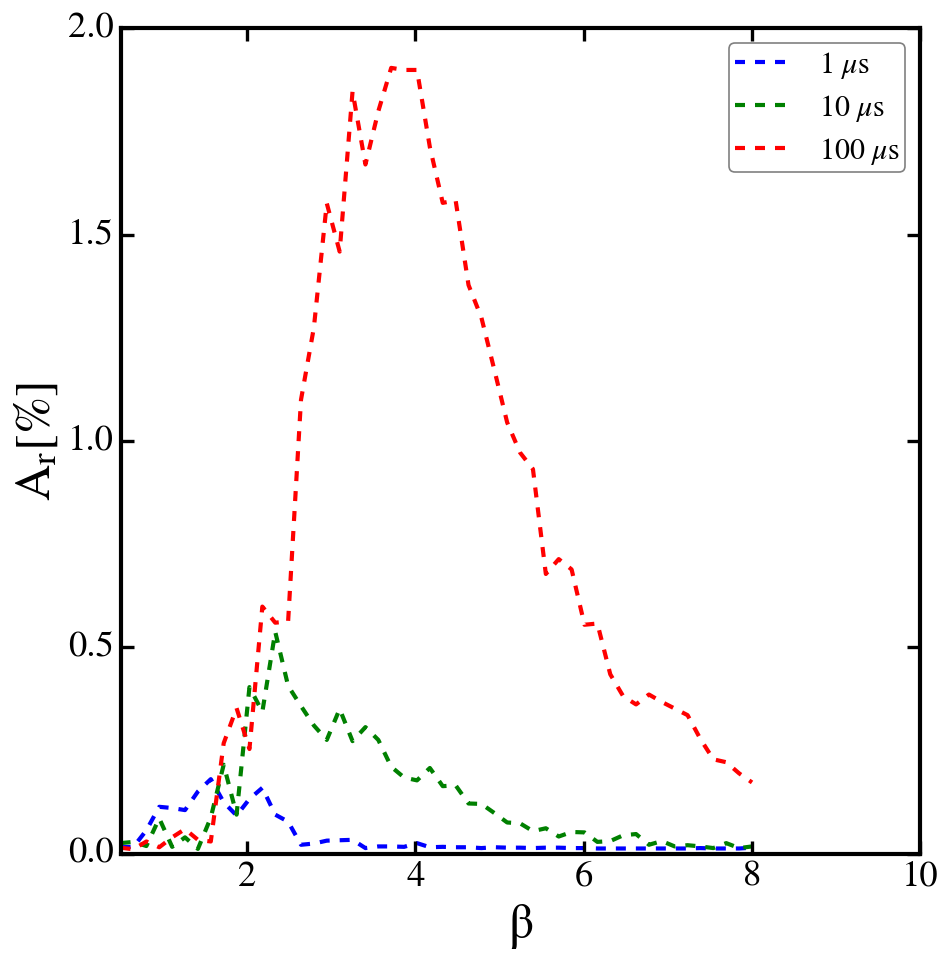

In [18]:
plt_betas_ar(acc_rates_3nn, labels_ar, betas_3nn, xlim=(0.5, 10), save=False)


#### Histograms $E/N$ varying $t_A$

Histograms of $4 \cdot 10^5$ configuration energies per spin $E/N$. The energy distribution for different annealing times show a clear shift to the lower-energy configuration when the annealing time increases Furthermore, with the longest annealing time D-Wave system sample configuration almost in the ground state (GS), even if the quantum annealer never reaches it. The data are obtained from the D-Wave quantum system after setting the annealing time, using several batches due the time constraints of a single D-Wave job. The horizontal red line is the ground state, computed using the McGroundstate solver.


1 $\mu$s
E: -1.0475328561010135 ± 2.328839823441583e-05
min: -1.0969759706962803 (1 occurance(s))                                                                    (s))

10 $\mu$s
E: -1.0675086354127463 ± 1.8316617586060988e-05
min: -1.0970910593355352 (1 occurance(s))                                                                    (s))

100 $\mu$s eng
E: -1.0782929306423352 ± 1.4771195420663153e-05
min: -1.0981585421367768  (1 occurance(s))


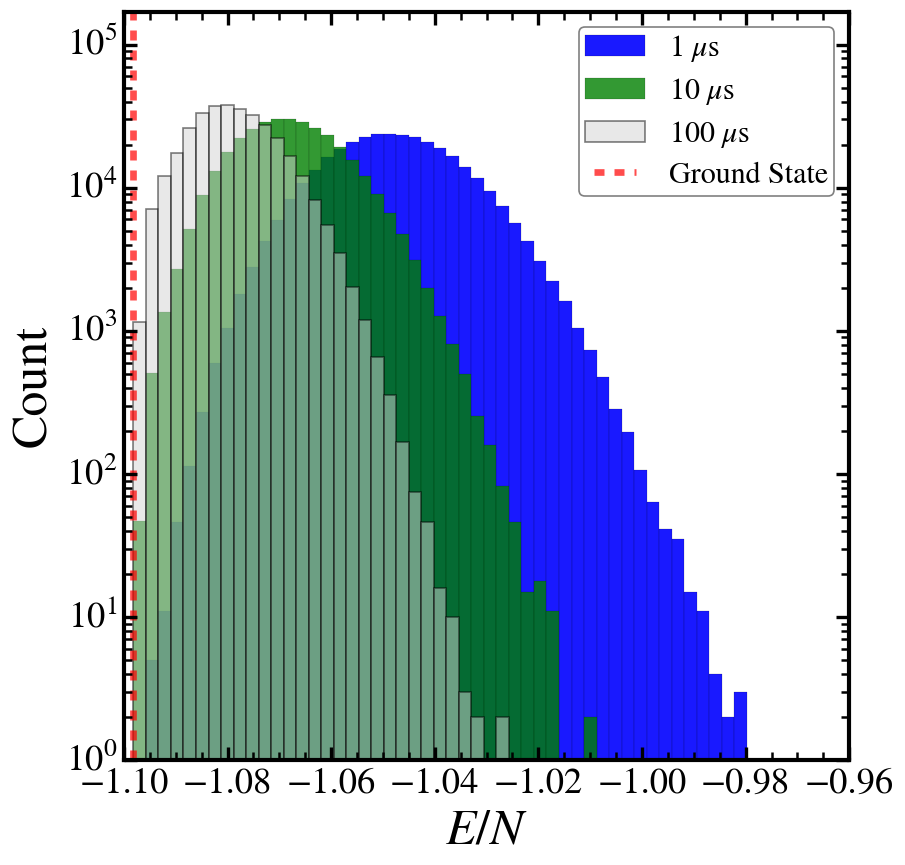

In [17]:
plot_hist(dwave_datasets_3nn[:2], couplings_path_3nn, dwave_datasets_3nn[2], 
        ground_state=ground_state_3nn, 
        labels=[r"1 $\mu$s", r"10 $\mu$s", r"100 $\mu$s"], save=False)


#### $E/N$ as a function of $\beta$



##### Long MCMC and Hybrid MCMC

Energy means obtained with a Hybrid Monte Carlo (H-MCMC) and a single spin-flip MCMC. For the hybrid simulation, we use $5 \cdot 10^5$ sample and for the single spin-flip $2 \cdot 10^5$ and 400 sweeps. For $\beta > 2$ the simulations become infeasible and they are not anymore a good benchmark for comparing the thermodynamic properties. Error bars are the error in the estimation of the mean, in the single spin-flip simulation they are the errors over 5 different simulations, started from different initial points. When the error bars are not visible means that they are too small to be shown. The horizontal red line is the ground state, computed using the McGroundstate solver. The vertical red line is the ground state, computed using the McGroundstate solver.


In [24]:
skip_hybrid_3nn = 50000
skip_single_3nn = 50000

hybrid_block_size_3nn = 2000
single_block_size_3nn = 2000

In [25]:
yerr_3nn = block_single_std(single_engs_long_3nn, len_block=single_block_size_3nn, skip=skip_single_3nn)
yerr_3nn = [
           np.abs(np.min(single_engs_long_3nn[..., skip_single_3nn:].mean(axis=2) 
           - yerr_3nn - single_engs_long_3nn[..., skip_single_3nn:].mean(axis=2).mean(0), axis=0)),
           np.abs(np.max(single_engs_long_3nn[..., skip_single_3nn:].mean(axis=2).mean(0) 
           - (single_engs_long_3nn[..., skip_single_3nn:].mean(axis=2) + yerr_3nn), axis=0))
           ]
yerr_3nn = np.asarray(yerr_3nn)

(2, 22)

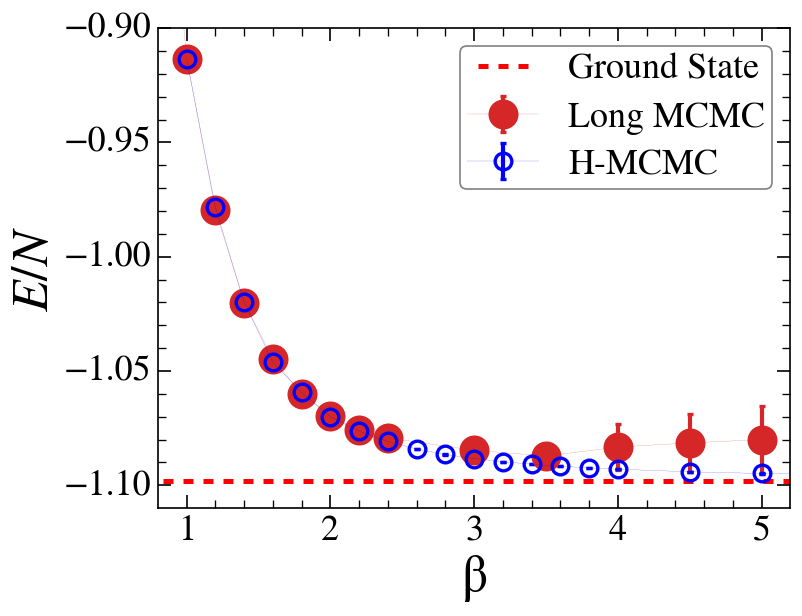

In [26]:
plt.errorbar(betas_single_3nn[::2], 
            [single_engs_long_3nn[..., 0, skip_single_3nn:].mean(axis=1).mean(axis=0)] 
            + single_engs_long_3nn[..., 1:16, skip_single_3nn:][:, ::2, :].mean(axis=2).mean(axis=0).tolist() 
            + single_engs_long_3nn[..., 17:, skip_single_3nn:].mean(axis=2).mean(axis=0).tolist(),
            yerr=np.concatenate((yerr_3nn[:, 0][..., None], yerr_3nn[:, 1:16][:, ::2], yerr_3nn[:, 17:]), axis=1), 
            elinewidth=2.5, linewidth=.1, marker='o', color='tab:red', mec='tab:red', fillstyle='full', 
            markersize=16, markeredgewidth=2, capsize=2, label=r"Long MCMC")
plt.errorbar(betas_hybrid_3nn[::2], np.append(np.asarray(eng_seq_hybrid_3nn)[...,skip_hybrid_3nn:].mean(1)[:-7][::2], 
            np.asarray(eng_seq_hybrid_3nn)[...,skip_hybrid_3nn:].mean(1)[-7:]),
            yerr=block_std(eng_seq_hybrid_3nn[:-7][::2], hybrid_block_size_3nn, skip=skip_hybrid_3nn) 
            + block_std(eng_seq_hybrid_3nn[-7:], hybrid_block_size_3nn, skip=skip_hybrid_3nn), 
            elinewidth=2.5, linewidth=.1, marker='o', markersize=10, markeredgewidth=2, capsize=2, 
            fillstyle='none', label=r"H-MCMC")

plt.hlines(ground_state_3nn, xmin=0., xmax=13, colors='red', linestyles='dashed', label="Ground State", 
           linewidth=3)
#plt.hlines(ground_state_3nn, xmin=0, xmax=1/0.4, colors='red', linestyles='dashed', label="Ground State", linewidth=3)

plt.xlim(0.8, 5.2)
plt.ylim(-1.11, -0.9)

plt.ylabel(r"$E/N$")
plt.xlabel(r"$\mathrm{\beta}$")

plt.legend()

plt.savefig("images/energy-beta_longmcmc-3nn.png")
plt.savefig("images/energy-beta_longmcmc-3nn.eps")


##### Parallel Tempering and Hybrid MCMC

Energy means obtained with a Hybrid Monte Carlo (H-MCMC) and a Parallel Tempering (PT-MCMC). For the hybrid simulation, we use $5 \cdot 10^5$ sample and for the PT-MCMC $5 \cdot 10^5$ sample per temperatures. We exploit calculation with 40 CPUs, choosing the temperatures in order to have a fixed estimate swap probability between adjacent simulations, i.e., $A_{swap} := \exp{\left[ \Delta \beta \Delta E \right] }  > 0.2$. Error bars are not visible since they are too small. The horizontal red line is the ground state, computed using the McGroundstate solver.

In [27]:
skip_hybrid_3nn = 50000
skip_parallel_3nn = 20000

single_block_size_3nn = 2000
parallel_block_size_3nn = 2000

In [28]:
# compute error bar
yerr_parallel_3nn = block_std(
    energies_parallel_3nn, len_block=parallel_block_size_3nn, skip=skip_parallel_3nn
    )

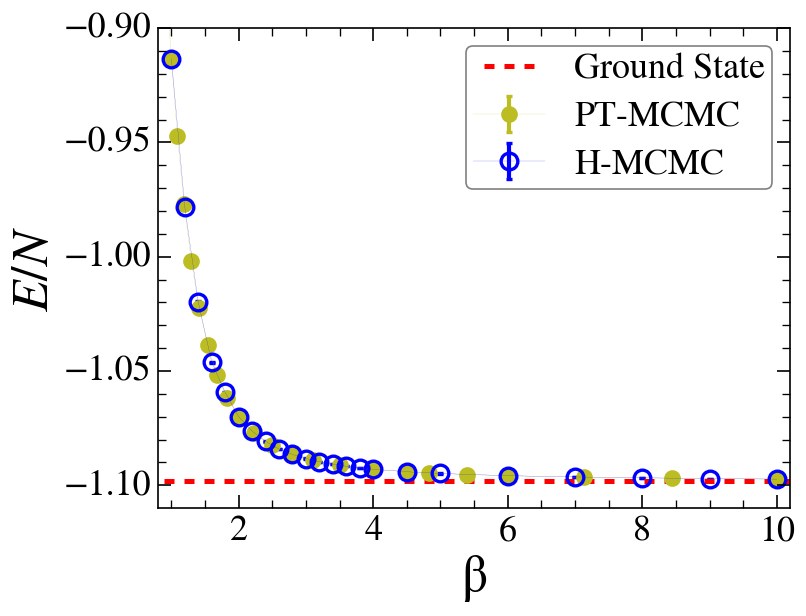

In [29]:
plt.errorbar(1/T, energies_parallel_3nn[..., skip_parallel_3nn:].mean(axis=1), 
    yerr=yerr_parallel_3nn, elinewidth=2.5, linewidth=.1, marker='o', color='tab:olive', mec='tab:olive',
    fillstyle='full', markersize=8, markeredgewidth=2, capsize=2, label=r"PT-MCMC",
    )
plt.errorbar(betas_hybrid_3nn[::2], np.append(np.asarray(eng_seq_hybrid_3nn)[...,skip_hybrid_3nn:].mean(1)[:-7][::2], 
            np.asarray(eng_seq_hybrid_3nn)[...,skip_hybrid_3nn:].mean(1)[-7:]),
            yerr=block_std(eng_seq_hybrid_3nn[:-7][::2], hybrid_block_size_3nn, skip=skip_hybrid_3nn) 
            + block_std(eng_seq_hybrid_3nn[-7:], hybrid_block_size_3nn, skip=skip_hybrid_3nn), 
            elinewidth=2.5, linewidth=.1, marker='o', markersize=10, markeredgewidth=2, capsize=2, 
            fillstyle='none', label=r"H-MCMC")

plt.hlines(ground_state_3nn, xmin=0., xmax=13, colors='red', linestyles='dashed', label="Ground State", 
           linewidth=3)
#plt.hlines(ground_state_3nn, xmin=0, xmax=1/0.4, colors='red', linestyles='dashed', label="Ground State", linewidth=3)

plt.xlim(0.8, 10.2)
plt.ylim(-1.11, -0.9)

plt.ylabel(r"$E/N$")
plt.xlabel(r"$\mathrm{\beta}$")

plt.legend()

plt.savefig("images/energy-beta_longmcmc-3nn.png")
plt.savefig("images/energy-beta_longmcmc-3nn.eps")


##### Parallel Tempering, Hybrid MCMC and SSF-MCMC

Energy means obtained with a Hybrid Monte Carlo (H-MCMC) and a Parallel Tempering (PT-MCMC). For the hybrid simulation, we use $5 \cdot 10^5$ sample, for the PT-MCMC $5 \cdot 10^5$ sample per temperatures and for the single spin-flip $2 \cdot 10^5$ and 400 sweeps. We exploit calculation with 40 CPUs, choosing the temperatures in order to have a fixed estimate swap probability between adjacent simulations, i.e., $A_{swap} := \exp{\left[ \Delta \beta \Delta E \right] }  > 0.2$. Error bars are not visible since they are too small. The horizontal red line is the ground state, computed using the McGroundstate solver.

In [30]:
skip_hybrid_3nn = 50000
skip_parallel_3nn = 20000
skip_single_3nn = 50000

hybrid_block_size_3nn = 2000
parallel_block_size_3nn = 2000
single_block_size_3nn = 2000

In [31]:
# compute error bar
yerr_parallel_3nn = block_std(
    energies_parallel_3nn, len_block=parallel_block_size_3nn, skip=skip_parallel_3nn
    )

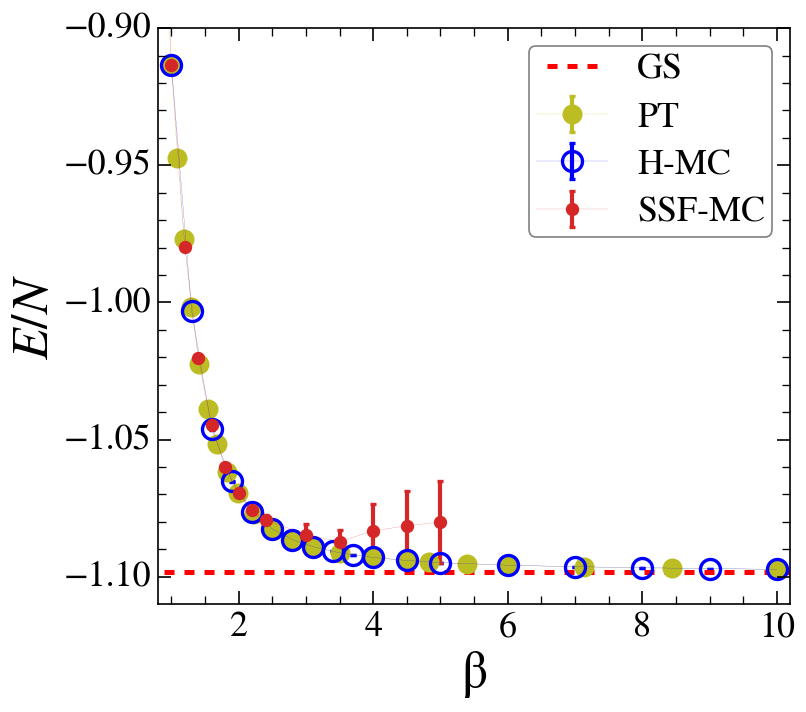

In [32]:
fig, ax = plt.subplots(1,1, figsize=(6.8,6.))

plt.errorbar(1/T, energies_parallel_3nn[..., skip_parallel_3nn:].mean(axis=1), 
    yerr=yerr_parallel_3nn, elinewidth=2.5, linewidth=.1, marker='o', color='tab:olive', mec='tab:olive',
    fillstyle='full', markersize=10, markeredgewidth=2, capsize=2, label=r"PT",
    )
plt.errorbar(betas_hybrid_3nn_all[::3], np.append(np.asarray(eng_seq_hybrid_3nn)[...,skip_hybrid_3nn:].mean(1)[:-7][::3], 
            np.asarray(eng_seq_hybrid_3nn)[...,skip_hybrid_3nn:].mean(1)[-7:]),
            yerr=block_std(eng_seq_hybrid_3nn[:-7][::3], hybrid_block_size_3nn, skip=skip_hybrid_3nn) 
            + block_std(eng_seq_hybrid_3nn[-7:], hybrid_block_size_3nn, skip=skip_hybrid_3nn), 
            elinewidth=2.5, linewidth=.1, marker='o', markersize=12, markeredgewidth=2, capsize=2, 
            fillstyle='none', label=r"H-MC")
plt.errorbar(betas_single_3nn[::2], 
            [single_engs_long_3nn[..., 0, skip_single_3nn:].mean(axis=1).mean(axis=0)] 
            + single_engs_long_3nn[..., 1:16, skip_single_3nn:][:, ::2, :].mean(axis=2).mean(axis=0).tolist() 
            + single_engs_long_3nn[..., 17:, skip_single_3nn:].mean(axis=2).mean(axis=0).tolist(),
            yerr=np.concatenate((yerr_3nn[:, 0][..., None], yerr_3nn[:, 1:16][:, ::2], yerr_3nn[:, 17:]), axis=1), 
            elinewidth=2.5, linewidth=.1, marker='o', color='tab:red', mec='tab:red', fillstyle='full', 
            markersize=6, markeredgewidth=2, capsize=2, label=r"SSF-MC")

plt.hlines(ground_state_3nn, xmin=0., xmax=13, colors='red', linestyles='dashed', label="GS", 
           linewidth=3)
#plt.hlines(ground_state_3nn, xmin=0, xmax=1/0.4, colors='red', linestyles='dashed', label="Ground State", linewidth=3)

plt.xlim(0.8, 10.2)
plt.ylim(-1.11, -0.9)

plt.ylabel(r"$E/N$")
plt.xlabel(r"$\mathrm{\beta}$")

plt.legend()

plt.savefig("images/energy-beta_longmcmc-3nn.png")
plt.savefig("images/energy-beta_longmcmc-3nn.eps")


#### Histograms $E/N$ low-temperatures regime

Histograms of $4 \cdot 10^5$ configuration energies per spin $E/N$ (zoom at low energy). The grey columns correspond to a Hybrid simulation at $\beta = 10$, the blue ones indicate the data obtained from the D-Wave at $T_A = 100 \mu s$ and the orange ones are generated from the MADE trained with the D-Wave's dataset. The vertical red line is the ground state, computed using the McGroundstate solver.


D-Wave
E: -1.0782929306423352 ± 1.4771195420663153e-05
min: -1.0981585421367768 (1 occurance(s))                                                                    (s))

MADE
E: -1.0765944904001108 ± 9.976132232200418e-06
min: -1.09809460059628 (1 occurance(s))                                                                    (s))

H-MC eng
E: -1.0972642811272075 ± 8.487373194672803e-07
min: -1.0981926008512388  (2476 occurance(s))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<AxesSubplot:xlabel='$E/N$', ylabel='Count'>

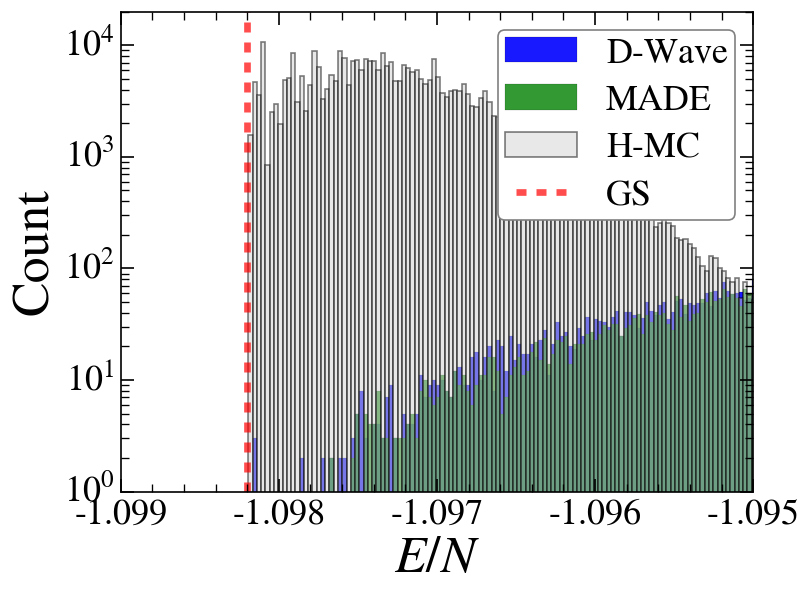

In [35]:
ticklables = [-1.099, -1.098, -1.097, -1.096, -1.095]

fig, ax = plt.subplots(1,1)
plot_hist(ax, [dwave_datasets_3nn[2], made_data_3nn[2]], couplings_path_3nn, 
        hybrid_paths[-1], ground_state=ground_state_3nn, 
        labels=[r"D-Wave", r"MADE", r"H-MC"], num_bins=4800, 
        xlim=(-1.099, -1.095), ylim=(0, 20000), ticklables=ticklables, 
        density=False, save=True)


#### Histograms $E/N$ low-temperatures regime

Histograms of $5 \cdot 10^5$ configuration energies per spin $E/N$.
Grey columns are samples obtained with the hybrid Monte Carlo and the blue columns are from a Parallel Tempering (PT-MCMC) ran with 40 CPUs and temperatures chosen to get $A_{swap} := \exp{\left[ \Delta \beta \Delta E \right] }  > 0.2$. The inverse temperature is $\beta = 10$ for both the simulations. The vertical red line is the ground state, computed using the McGroundstate solver.


PT
E: -1.0972844043387842 ± 9.686501921561485e-07
min: -1.0981926008516676 (1 occurance(s))                                                                    (s))

H-MC eng
E: -1.0972642811272075 ± 8.487373194672803e-07
min: -1.0981926008512388  (2476 occurance(s))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<AxesSubplot:xlabel='$E/N$', ylabel='Count'>

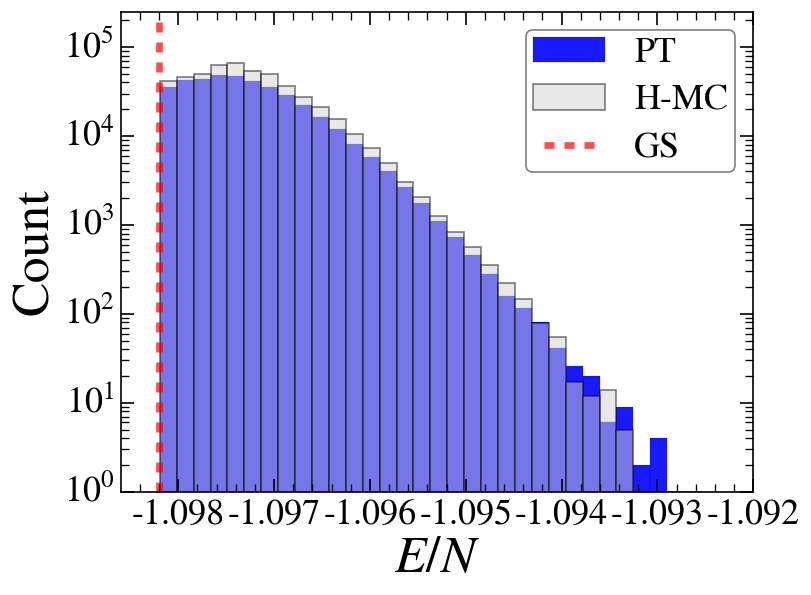

In [36]:
skip = 100000
ticklables = [-1.099, -1.098, -1.097, -1.096, -1.095, -1.094, -1.093, -1.092]
#ticklables=None

fig, ax = plt.subplots(1,1)

plot_hist(ax, [energies_parallel_3nn[0][skip:]], couplings_path_3nn, 
        hybrid_paths[-1], ground_state=ground_state_3nn, 
        labels=[r"PT", r"H-MC"], xlim=(-1.0986, -1.092), 
        ticklables=ticklables, density=False, num_bins=60, save=True)


#### Autocorrelation vs MCMC Steps (log scale)

Autocorrelation function $c(\tau)$ of the configuration energies. The dashed lines correspond to the Hybrid simulation, each one ran for $5 \cdot 10^5$ steps. The solid lines correspond to the single spin-flip simulation ran for $1.1 \cdot 10^7$ sweeps, only the last $10^6$ are used to compute the correlation.

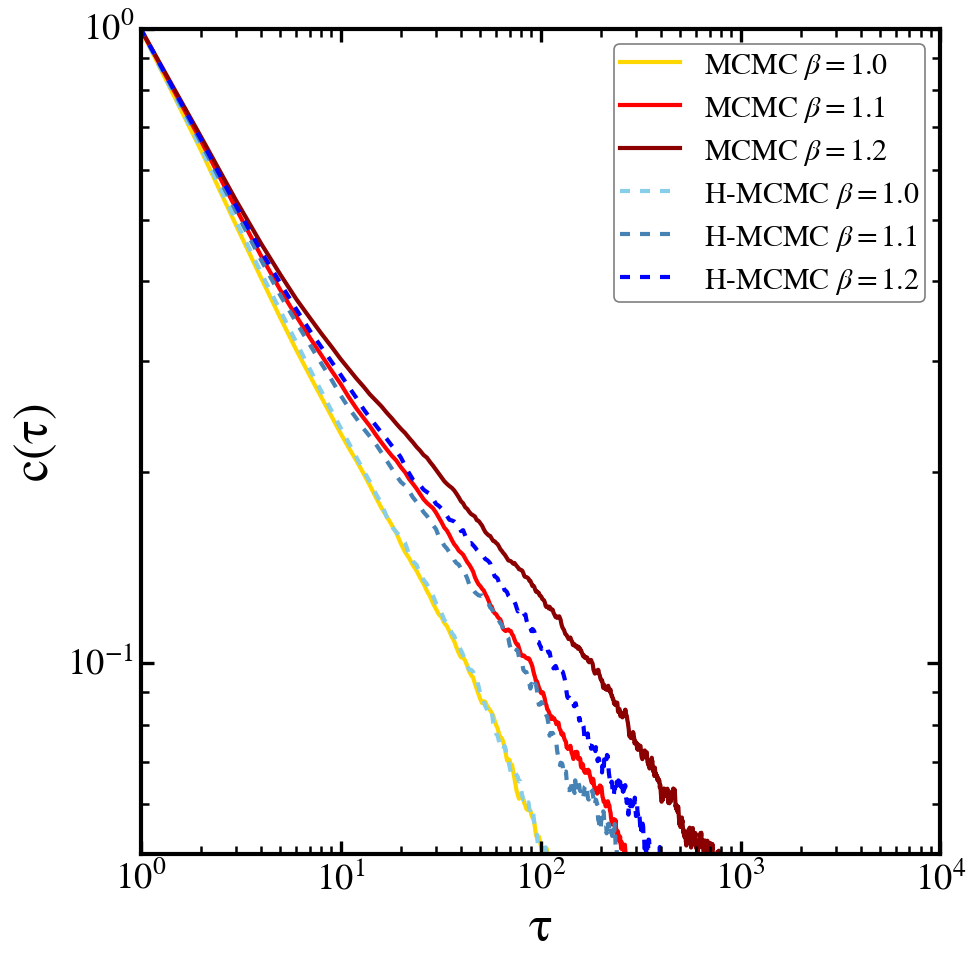

In [17]:
skip = 100000 #skip the first samples, used for thermalization
skip_hybid = 100000 #skip the first samples, used for thermalization

idxs_hybrid = [0, 1, 2]


ac_parallel_3nn = []
ac_single_3nn = []
ac_hybrid_3nn = []
for eng_1sweep in engs_1sweep:
    ac_single_3nn.append(acf(eng_1sweep[skip:], nlags=50000, fft=True))
    print()
for i, idx in enumerate(idxs_hybrid):    
    ac_hybrid_3nn.append(acf(eng_seq_hybrid_3nn[idx][skip_hybid:], nlags=50000, fft=True))
    print()

plt_acf(
    ac_single_3nn, 
    [r"MCMC $\beta=1.0$", r"MCMC $\beta=1.1$", r"MCMC $\beta=1.2$"], 
    ac_hybrid_3nn, 
    [r"H-MCMC $\beta=1.0$", r"H-MCMC $\beta=1.1$", r"H-MCMC $\beta=1.2$"], 
    ylim=(0.05, 1), 
    xlim=(1, 10000), 
    fit = False,
    save=False,
)


#### Autocorrelation vs MCMC Steps (log scale)

Autocorrelation function $c(\tau)$ of the configuration energies. The dashed lines correspond to the Hybrid simulation, each one ran for $5 \cdot 10^5$ steps. The solid lines correspond to the Parallel Tempering ran for $5 \cdot 10^5$ steps (1 sweep and a swap attempt) using 22 CPUs and $\beta \in [0.01, 10]$. The $\beta$ in the PT are chosen in a \emph{naive} way, uniformly in the log-scale keeping constant the ratio $T_i / T_j$, where  $T_i \text{ and } T_j$ represent adjacent temperatures.

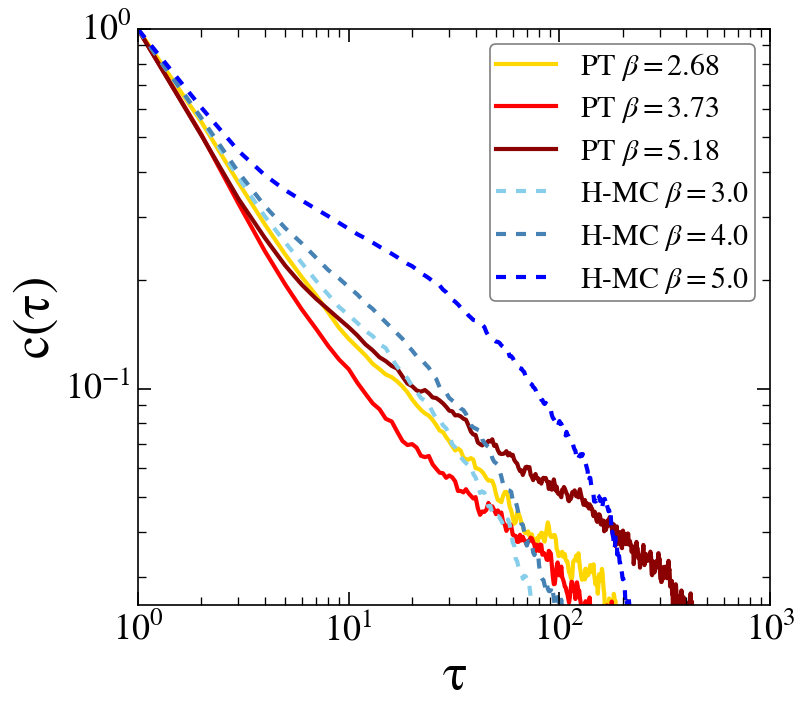

In [117]:
skip = 100000 #skip the first samples, used for thermalization
skip_hybid = 100000 #skip the first samples, used for thermalization

idxs = [4, 3, 2]
idxs_hybrid = [20, 30, 32]


ac_parallel_3nn = []
ac_hybrid_3nn = []
for i, idx in enumerate(idxs):
    ac_parallel_3nn.append(acf(energies_parallel_3nn_forcorr[idx][skip:], nlags=50000, 
    fft=True))

for i, idx in enumerate(idxs_hybrid):    
    ac_hybrid_3nn.append(acf(eng_seq_hybrid_3nn[idx][skip_hybid:], nlags=50000, 
    fft=True))

plt_acf(
    [ac_parallel_3nn[0], ac_parallel_3nn[1], ac_parallel_3nn[2]], 
    [r"PT $\beta=2.68$", r"PT $\beta=3.73$", r"PT $\beta=5.18$"], 
    ac_hybrid_3nn, 
    [r"H-MC $\beta=3.0$", r"H-MC $\beta=4.0$", r"H-MC $\beta=5.0$"], 
    ylim=(0.025, 1), 
    xlim=(1, 1000), 
    fit = False,
    save=True,
)


#### Energy vs Steps

Configuration energy per spin $E/N$ as a function of the number of steps $\tau$. A step $\tau$ for the hybrid algorithm (H-MCMC) is composed by a sweep and a neural proposal generated by MADE, whereas for the Parallel Tempering (PT-MCMC) a step is a sweep and a swap attempt. For both the simulations we consider $5 \cdot 10^5$ steps with a random initial configuration. The PT-MCMC ran using 40 CPUs and its temperature distribution is chosen such that the mean swap acceptance rate $A_{swap} := \exp{\left[ \Delta \beta \Delta E \right] }$ is always greater than $20\%$ for every adjacent simulation. The horizontal red line is the ground state, computed using the McGroundstate solver.

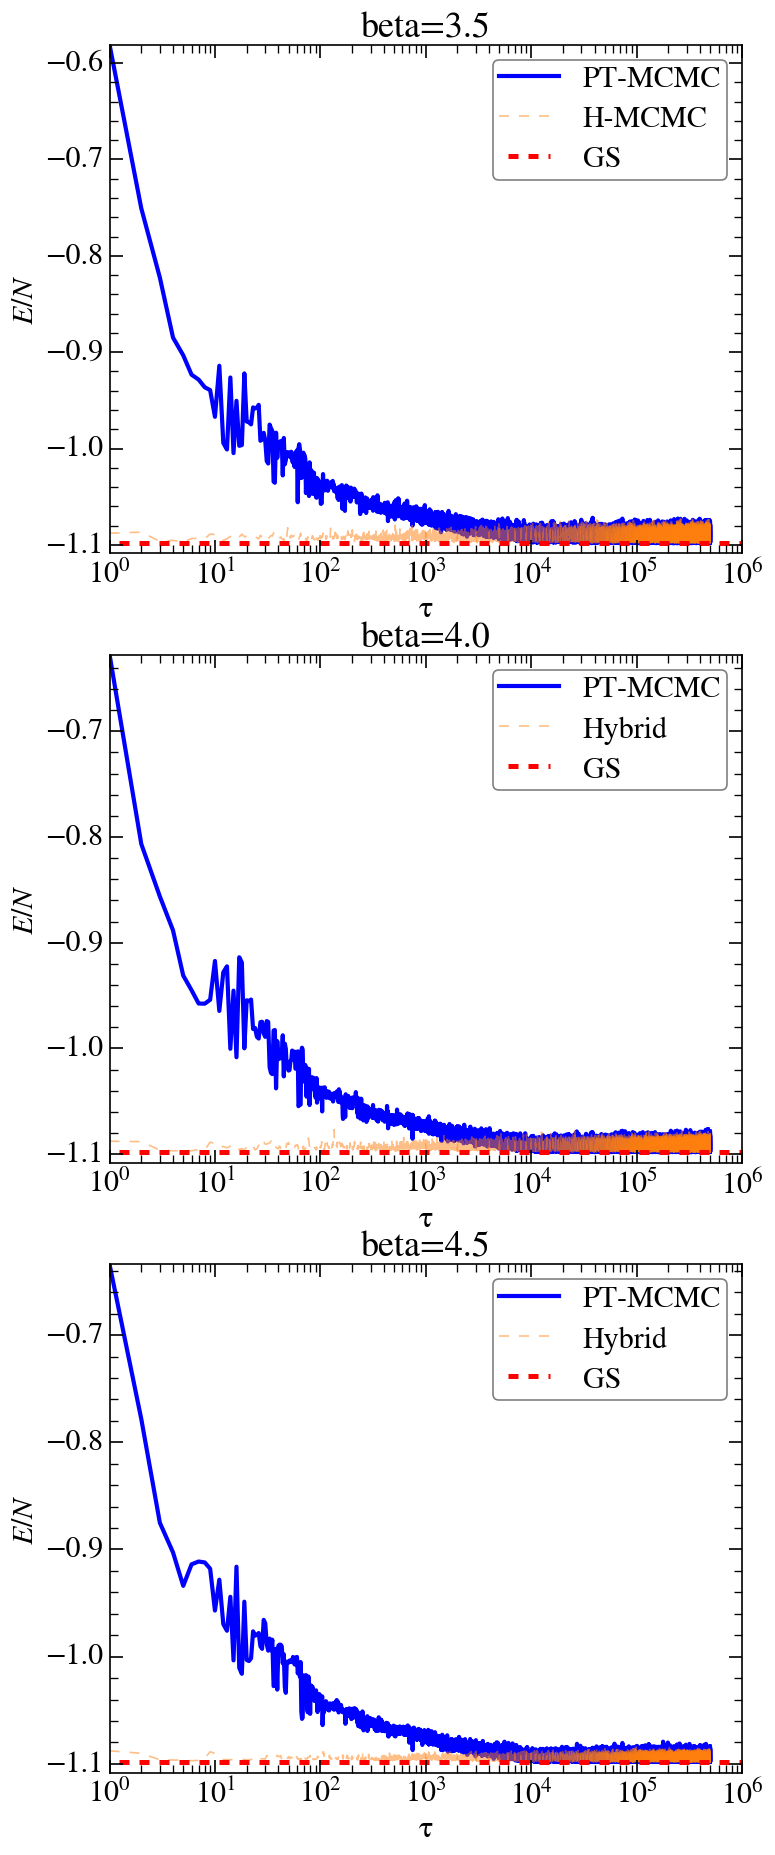

In [10]:
skip = 100000

fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(6.8,18))
for i, eng_parallel in enumerate(energies_parallel_3nn):
    ac_parallel = acf(eng_parallel[skip:], nlags=100000, fft=True)
    if i==8:
        #idxs_hybrid = [20, 30, 32]
        idx_hybrid = 25
        plt_eng_step(ax1, energies_parallel_3nn[i], eng_seq_hybrid_3nn[idx_hybrid], "PT-MCMC", r"H-MCMC", ground_state=ground_state_3nn,
            xlim=(1,1000000), title=f"beta={betas_hybrid_3nn[idx_hybrid]}")# and {1/T[i]}")
    elif i==7:
        #idxs_hybrid = [20, 30, 32]
        idx_hybrid = 30
        plt_eng_step(ax2, energies_parallel_3nn[i], eng_seq_hybrid_3nn[idx_hybrid], "PT-MCMC", r"Hybrid", ground_state=ground_state_3nn,
            xlim=(1,1000000), title=f"beta={betas_hybrid_3nn[idx_hybrid]}")# and {1/T[i]}")
    elif i==6:
        #idxs_hybrid = [20, 30, 32]
        idx_hybrid = 32
        plt_eng_step(ax3, energies_parallel_3nn[i], eng_seq_hybrid_3nn[idx_hybrid], "PT-MCMC", r"Hybrid", ground_state=ground_state_3nn,
            xlim=(1,1000000), title=f"beta={betas_hybrid_3nn[idx_hybrid]}")# and {1/T[i]}")


#### Energy vs Steps with SSF-MCMC)

Configuration energy per spin $E/N$ as a function of the number of steps $\tau$. A step $\tau$ for the hybrid algorithm (H-MCMC) is composed by a sweep and a neural proposal generated by MADE, whereas for the Parallel Tempering (PT-MCMC) a step is a sweep and a swap attempt. For both the simulations we consider $5 \cdot 10^5$ steps with a random initial configuration. The PT-MCMC ran using 40 CPUs and its temperature distribution is chosen such that the mean swap acceptance rate $A_{swap} := \exp{\left[ \Delta \beta \Delta E \right] }$ is always greater than $20\%$ for every adjacent simulation. Moreover, we plot for comparison the energy obtained with a SSF-MCMC, 5 simulations of $5 \cdot 10^5$ steps (1 step is 1 sweep) with different initial points, the shadow is the $\sigma$ over the 5 simulations.
The horizontal red line is the ground state, computed using the McGroundstate solver.

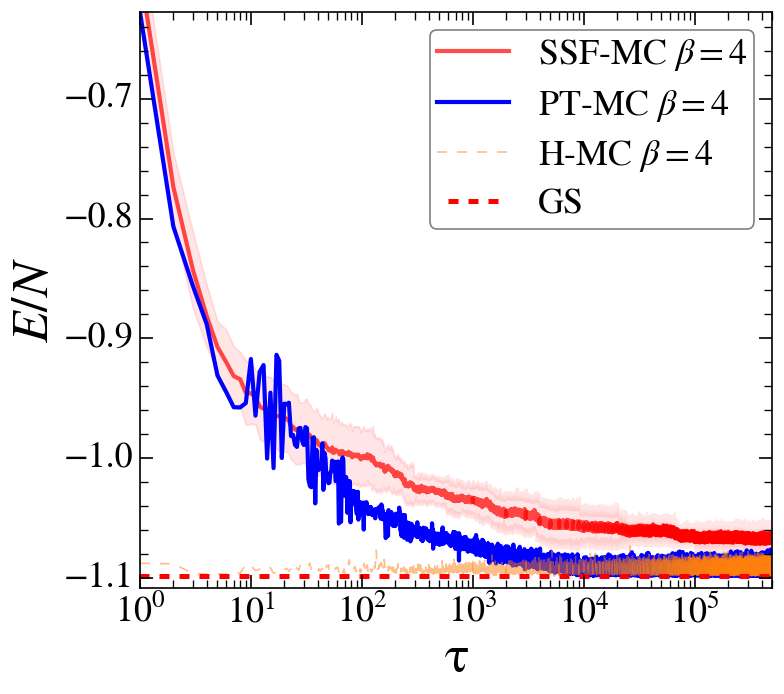

In [115]:
skip = 100000

for i, eng_parallel in enumerate(energies_parallel_3nn):
    if i==7:
        idx_hybrid = 30
        fig, ax = plt.subplots(1,1,figsize=(6.8,6.))
        ax.fill_between(
            np.arange(engs_1sweep_beta4.shape[-1]) + 1,
            engs_1sweep_beta4.mean(axis=0) + engs_1sweep_beta4.std(axis=0),
            engs_1sweep_beta4.mean(axis=0) - engs_1sweep_beta4.std(axis=0),
            alpha=0.1,
            color="r",
        )
        ax.plot(
            np.arange(engs_1sweep_beta4.shape[-1]) + 1, 
            engs_1sweep_beta4.mean(axis=0), label=r"SSF-MC $\beta=4$", 
            color="r", alpha=0.7
        )
        plt_eng_step(ax, energies_parallel_3nn[i], eng_seq_hybrid_3nn[idx_hybrid], 
        r"PT-MC $\beta=4$", r"H-MC $\beta=4$", ground_state=ground_state_3nn,
        xlim=(1,500000)) #, title=f"beta={betas_hybrid_3nn[idx_hybrid]}")# and {1/T[i]}")
        ax.legend(loc='best')
        plt.savefig(
                "images/energy-steps.png",
                facecolor=ax.get_facecolor(),
                bbox_inches="tight",
                transparent=False,
            )